In [ ]:
!pip install category_encoders
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 91 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Se cargan los datos
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# Se elimina la columna índice
df_train = df_train.drop(['Id'], axis=1)
indice = df_test['Id']
df_test = df_test.drop(['Id'], axis=1)

In [ ]:
# Se visualizan los tipos de las variables de las columnas
df_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [ ]:
# Se cambian las variables que son categóricas de int a str
df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

In [ ]:
# Se obtienen las columnas con varibles categoricas
num_vars = [var for var in df_train.columns if df_train[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))
print(num_vars)

Number of numerical variables:  35
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']


In [ ]:
# Se obtienen las columnas con varibles categoricas
cat_vars = [var for var in df_train.columns if df_train[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_vars))
print(cat_vars)

Number of categorical variables:  45
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


### Outliers

In [ ]:
df_train.loc[(df_train["GarageYrBlt"]==2207), "GarageYrBlt"] = 2007

### Valores ausentes

In [ ]:
# Datos de entrenamiento
valores_nulos = df_train.isnull().sum()
valores_nulos.sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
dtype: int64

In [ ]:
# Datos del test final
valores_nulos_test = df_test.isnull().sum()
valores_nulos_test.sort_values(ascending = False).head(35)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
SaleType           1
BsmtFinSF1         1
GarageCars         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
GarageArea         1
BsmtFinSF2         1
TotRmsAbvGrd       0
KitchenAbvGr       0
dtype: int64

In [ ]:
# SUSTITUCIÓN DE LOS VALORES NULOS

# se cambian los valores ausentes por el valor "No_Pool"
df_train["PoolQC"] = df_train["PoolQC"].fillna("No_Pool")
df_test["PoolQC"] = df_test["PoolQC"].fillna("No_Pool")
# se cambian los valores ausentes por el valor "None"
df_train["MiscFeature"] = df_train["MiscFeature"].fillna("None")
df_test["MiscFeature"] = df_test["MiscFeature"].fillna("None")
# se cambian los valores ausentes por el valor "No_Alley"
df_train["Alley"] = df_train["Alley"].fillna("No_Alley")
df_test["Alley"] = df_test["Alley"].fillna("No_Alley")
# se cambian los valores ausentes por el valor "No_Fence"
df_train["Fence"] = df_train["Fence"].fillna("No_Fence")
df_test["Fence"] = df_test["Fence"].fillna("No_Fence")
# se cambian los valores ausentes por el valor "No_Fireplace"
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("No_Fireplace")
df_test["FireplaceQu"] = df_test["FireplaceQu"].fillna("No_Fireplace")
# se cambian los valores ausentes por el valor "No_Garage"
df_train["GarageCond"] = df_train["GarageCond"].fillna("No_Garage")
df_test["GarageCond"] = df_test["GarageCond"].fillna("No_Garage")
# se cambian los valores ausentes por el valor "No_Garage"
df_train["GarageType"] = df_train["GarageType"].fillna("No_Garage")
df_test["GarageType"] = df_test["GarageType"].fillna("No_Garage")
# se cambian los valores ausentes por el valor "No_Garage"
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("No_Garage")
df_test["GarageFinish"] = df_test["GarageFinish"].fillna("No_Garage")
# se cambian los valores ausentes por el valor "No_Garage"
df_train["GarageQual"] = df_train["GarageQual"].fillna("No_Garage")
df_test["GarageQual"] = df_test["GarageQual"].fillna("No_Garage")
# se cambian los valores ausentes por el valor "No_Basement"
df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("No_Basement")
df_test["BsmtExposure"] = df_test["BsmtExposure"].fillna("No_Basement")
# se cambian los valores ausentes por el valor "No_Basement"
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("No_Basement")
df_test["BsmtFinType2"] = df_test["BsmtFinType2"].fillna("No_Basement")
# se cambian los valores ausentes por el valor "No_Basement"
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("No_Basement")
df_test["BsmtCond"] = df_test["BsmtCond"].fillna("No_Basement")
# se cambian los valores ausentes por el valor "No_Basement"
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("No_Basement")
df_test["BsmtQual"] = df_test["BsmtQual"].fillna("No_Basement")
# se cambian los valores ausentes por el valor "No_Basement"
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("No_Basement")
df_test["BsmtFinType1"] = df_test["BsmtFinType1"].fillna("No_Basement")
# Se cambian los 8 valores nulos por el valor 'None' que es el más veces se repite
df_train["MasVnrType"] = df_train["MasVnrType"].fillna("None")
df_test["MasVnrType"] = df_test["MasVnrType"].fillna("None")
# Se cambia el valor nulo por el valor 'SBrkr' que es el más veces se repite
df_train["Electrical"] = df_train["Electrical"].fillna("SBrkr")
df_test["Electrical"] = df_test["Electrical"].fillna("SBrkr")
# Se sustituyen los valores nulos por la media de toda la columna
df_train["LotFrontage"] = df_train["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
df_test["LotFrontage"] = df_test["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
# Se sustituyen los valores nulos por el año de construcción de la casa 'YearBuilt'
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].transform(lambda x: x.fillna(df_train["YearBuilt"]))
df_test["GarageYrBlt"] = df_test["GarageYrBlt"].transform(lambda x: x.fillna(df_test["YearBuilt"]))
# Se sustituyen los 8 valores nulos por 0 debido a que en estos casos se ha sustituido el valor de la columna 'MasVnrType' por el valor 'None'
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(0)
df_test["MasVnrArea"] = df_test["MasVnrArea"].fillna(0)

In [ ]:
# Datos de entrenamiento
valores_nulos = df_train.isnull().sum()
valores_nulos.sort_values(ascending = False).head()

MSSubClass     0
MSZoning       0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
dtype: int64

In [ ]:
# Datos del test final
valores_nulos_test = df_test.isnull().sum()
valores_nulos_test.sort_values(ascending = False).head(16)

MSZoning        4
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
Functional      2
BsmtFinSF1      1
KitchenQual     1
Exterior1st     1
GarageCars      1
GarageArea      1
Exterior2nd     1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
SaleType        1
HalfBath        0
dtype: int64

In [ ]:
# Se eliminan los datos nulos que solo se encuentran en los datos del test final
# SUSTITUCIÓN DE LOS VALORES NULOS

# Se sustituyen los 2 valores nulos por 0 debido a que es el más frecuente
df_test["BsmtFullBath"] = df_test["BsmtFullBath"].fillna(0)
# Se sustituyen los 2 valores nulos por la media de toda la columna
df_test["BsmtHalfBath"] = df_test["BsmtHalfBath"].transform(lambda x: x.fillna(x.mean()))
# Se sustituye el valor nulo por la media de toda la columna
df_test["TotalBsmtSF"] = df_test["TotalBsmtSF"].transform(lambda x: x.fillna(x.mean()))
# Se sustituye el valor nulo por la media de toda la columna
df_test["BsmtUnfSF"] = df_test["BsmtUnfSF"].transform(lambda x: x.fillna(x.mean()))
# Se sustituye el valor nulo por la media de toda la columna
df_test["BsmtFinSF2"] = df_test["BsmtFinSF2"].transform(lambda x: x.fillna(x.mean()))
# Se sustituye el valor nulo por 2 debido a que es el más frecuente
df_test["GarageCars"] = df_test["GarageCars"].fillna(2)
# Se sustituye el valor nulo por la media de toda la columna
df_test["BsmtFinSF1"] = df_test["BsmtFinSF1"].transform(lambda x: x.fillna(x.mean()))
# Se sustituye el valor nulo por la media de toda la columna
df_test["GarageArea"] = df_test["GarageArea"].transform(lambda x: x.fillna(x.mean()))
# Se sustituyen los 4 valores nulos por 'RL' debido a que es el más frecuente
df_test["MSZoning"] = df_test["MSZoning"].fillna('RL')
# Se sustituyen los 2 valores nulos por 'AllPub' debido a que es el más frecuente
df_test["Utilities"] = df_test["Utilities"].fillna('AllPub')
# Se sustituyen los 2 valores nulos por 'Typ' debido a que es el más frecuente
df_test["Functional"] = df_test["Functional"].fillna('Typ')
# Se sustituye el valor nulo por 'VinylSd' debido a que es el más frecuente
df_test["Exterior2nd"] = df_test["Exterior2nd"].fillna('VinylSd')
# Se sustituye el valor nulo por 'TA' debido a que es el más frecuente
df_test["KitchenQual"] = df_test["KitchenQual"].fillna('TA')
# Se sustituye el valor nulo por 'WD' debido a que es el más frecuente
df_test["SaleType"] = df_test["SaleType"].fillna('WD')
# Se sustituye el valor nulo por 'VinylSd' debido a que es el más frecuente
df_test["Exterior1st"] = df_test["Exterior1st"].fillna('VinylSd')

In [ ]:
# Datos del test final
valores_nulos_test = df_test.isnull().sum()
valores_nulos_test.sort_values(ascending = False).head()

MSSubClass      0
BedroomAbvGr    0
GarageType      0
FireplaceQu     0
Fireplaces      0
dtype: int64

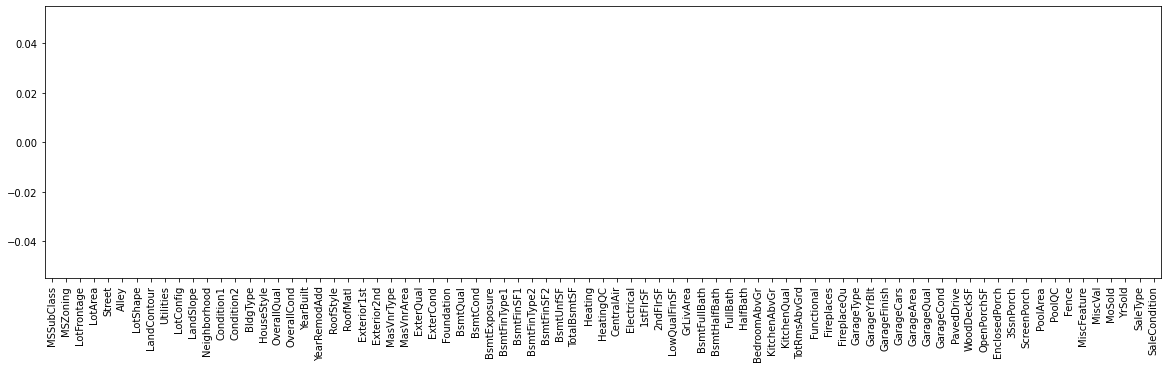

In [ ]:
# Se comprueba que no quedan valores nulos en los datos de test
df_test.isna().sum().plot(kind="bar", figsize=(20, 5));

# VARIABLES CATEGÓRICAS

### Conversión de las variables categóricas

In [ ]:
df_cat = pd.DataFrame()
for x in cat_vars:
    df_cat[x] = df_train[x]
df_cat['SalePrice'] = df_train['SalePrice']
df_cat.head()

MSSubClass MSZoning Street     Alley LotShape LandContour Utilities  \
0         60       RL   Pave  No_Alley      Reg         Lvl    AllPub   
1         20       RL   Pave  No_Alley      Reg         Lvl    AllPub   
2         60       RL   Pave  No_Alley      IR1         Lvl    AllPub   
3         70       RL   Pave  No_Alley      IR1         Lvl    AllPub   
4         60       RL   Pave  No_Alley      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood  ... GarageQual GarageCond PavedDrive  \
0    Inside       Gtl      CollgCr  ...         TA         TA          Y   
1       FR2       Gtl      Veenker  ...         TA         TA          Y   
2    Inside       Gtl      CollgCr  ...         TA         TA          Y   
3    Corner       Gtl      Crawfor  ...         TA         TA          Y   
4       FR2       Gtl      NoRidge  ...         TA         TA          Y   

    PoolQC     Fence MiscFeature MoSold SaleType SaleCondition SalePrice  
0  No_Pool  No_Fence        None      2       WD        Normal    208500  
1  No_Pool  No_Fence        None      5       WD        Normal    181500  
2  No_Pool  No_Fence        None      9       WD        Normal    223500  
3  No_Pool  No_Fence        None      2       WD       Abnorml    140000  
4  No_Pool  No_Fence        None     12       WD        Normal    250000  

[5 rows x 46 columns]

In [ ]:
df_test1 = df_test.copy()
df_test1.head()

MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape  \
0         20       RH         80.0    11622   Pave  No_Alley      Reg   
1         20       RL         81.0    14267   Pave  No_Alley      IR1   
2         60       RL         74.0    13830   Pave  No_Alley      IR1   
3         60       RL         78.0     9978   Pave  No_Alley      IR1   
4        120       RL         43.0     5005   Pave  No_Alley      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea   PoolQC  \
0         Lvl    AllPub    Inside  ...         120        0  No_Pool   
1         Lvl    AllPub    Corner  ...           0        0  No_Pool   
2         Lvl    AllPub    Inside  ...           0        0  No_Pool   
3         Lvl    AllPub    Inside  ...           0        0  No_Pool   
4         HLS    AllPub    Inside  ...         144        0  No_Pool   

      Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0     MnPrv        None       0       6    2010        WD         Normal  
1  No_Fence        Gar2   12500       6    2010        WD         Normal  
2     MnPrv        None       0       3    2010        WD         Normal  
3  No_Fence        None       0       6    2010        WD         Normal  
4  No_Fence        None       0       1    2010        WD         Normal  

[5 rows x 79 columns]

In [ ]:
# Lista que contiene todas las variables categoricas que tienen orden numérico
list_var_cat = []

In [ ]:
# ExterQual: Evaluates the quality of the material on the exterior 
ExterQual = {}
ExterQual['Ex'] = 5 #'Excellent'
ExterQual['Gd'] = 4 #'Good'
ExterQual['TA'] = 3 #'Average/Typical'
ExterQual['Fa'] = 2 #'Fair'
ExterQual['Po'] = 1 #'Poor'
ExterQual['NA'] = 0 #'NA'

df_train.ExterQual = df_train.ExterQual.map(ExterQual)
df_test.ExterQual = df_test.ExterQual.map(ExterQual)
print('train', df_train['ExterQual'].unique())
print('test', df_test['ExterQual'].unique())
list_var_cat.append('ExterQual')

train [4 3 5 2]
test [3 4 5 2]


Correlación:  0.6826392416562594


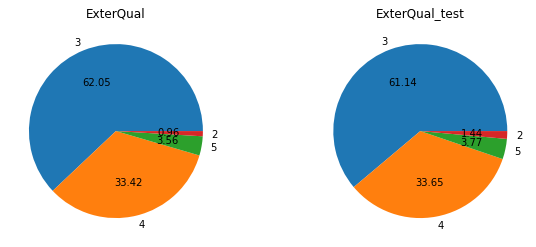

In [ ]:
print('Correlación: ', df_train['ExterQual']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["ExterQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="ExterQual")
df_test["ExterQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="ExterQual_test")

In [ ]:
# ExterCond: Evaluates the present condition of the material on the exterior
ExterCond = {}
ExterCond['Ex'] = 5 #'Excellent'
ExterCond['Gd'] = 4 #'Good'
ExterCond['TA'] = 3 #'Average/Typical'
ExterCond['Fa'] = 2 #'Fair'
ExterCond['Po'] = 1 #'Poor'
ExterCond['NA'] = 0 #'NA'

df_train.ExterCond = df_train.ExterCond.map(ExterCond)
df_test.ExterCond = df_test.ExterCond.map(ExterCond)
print('train', df_train['ExterCond'].unique())
print('test', df_test['ExterCond'].unique())
list_var_cat.append('ExterCond')

train [3 4 2 1 5]
test [3 4 2 1 5]


Correlación:  0.018899118482413015


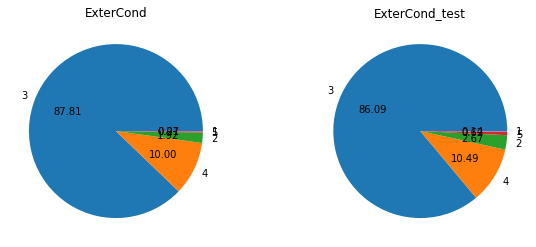

In [ ]:
print('Correlación: ', df_train['ExterCond']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["ExterCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="ExterCond")
df_test["ExterCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="ExterCond_test")

In [ ]:
# HeatingQC: Heating quality and condition
HeatingQC = {}
HeatingQC['Ex'] = 5 #'Excellent'
HeatingQC['Gd'] = 4 #'Good'
HeatingQC['TA'] = 3 #'Average/Typical'
HeatingQC['Fa'] = 2 #'Fair'
HeatingQC['Po'] = 1 #'Poor'
HeatingQC['NA'] = 0 #'NA'

df_train.HeatingQC = df_train.HeatingQC.map(HeatingQC)
df_test.HeatingQC = df_test.HeatingQC.map(HeatingQC)
print('train', df_train['HeatingQC'].unique())
print('test', df_test['HeatingQC'].unique())
list_var_cat.append('HeatingQC')

train [5 4 3 2 1]
test [3 4 5 2 1]


Correlación:  0.427648707398804


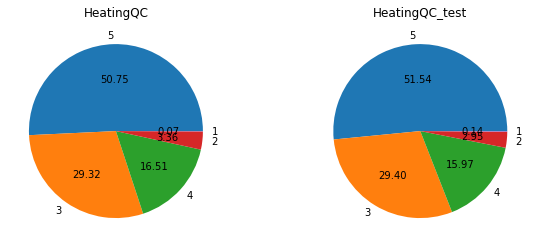

In [ ]:
print('Correlación: ', df_train['HeatingQC']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["HeatingQC"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="HeatingQC")
df_test["HeatingQC"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="HeatingQC_test")

In [ ]:
# KitchenQual: Kitchen quality
KitchenQual = {}
KitchenQual['Ex'] = 5 #'Excellent'
KitchenQual['Gd'] = 4 #'Good'
KitchenQual['TA'] = 3 #'Average/Typical'
KitchenQual['Fa'] = 2 #'Fair'
KitchenQual['Po'] = 1 #'Poor'
KitchenQual['NA'] = 0 #'NA'

df_train.KitchenQual = df_train.KitchenQual.map(KitchenQual)
df_test.KitchenQual = df_test.KitchenQual.map(KitchenQual)
print('train', df_train['KitchenQual'].unique())
print('test', df_test['KitchenQual'].unique())
list_var_cat.append('KitchenQual')

train [4 3 5 2]
test [3 4 5 2]


Correlación:  0.6595997207286639


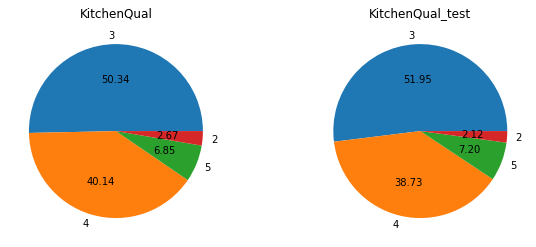

In [ ]:
print('Correlación: ', df_train['KitchenQual']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["KitchenQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="KitchenQual")
df_test["KitchenQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="KitchenQual_test")

In [ ]:
# FireplaceQu: Fireplace quality
FireplaceQu = {}
FireplaceQu['Ex'] = 5 #'Excellent'
FireplaceQu['Gd'] = 4 #'Good'
FireplaceQu['TA'] = 3 #'Average/Typical'
FireplaceQu['Fa'] = 2 #'Fair'
FireplaceQu['Po'] = 1 #'Poor'
FireplaceQu['No_Fireplace'] = 0 #'NA'

df_train.FireplaceQu = df_train.FireplaceQu.map(FireplaceQu)
df_test.FireplaceQu = df_test.FireplaceQu.map(FireplaceQu)
print('train', df_train['FireplaceQu'].unique())
print('test', df_test['FireplaceQu'].unique())
list_var_cat.append('FireplaceQu')

train [0 3 4 2 5 1]
test [0 3 4 1 2 5]


Correlación:  0.5204376059504016


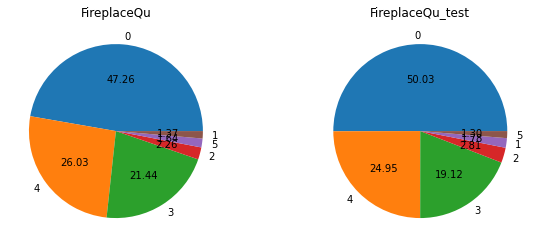

In [ ]:
print('Correlación: ', df_train['FireplaceQu']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["FireplaceQu"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="FireplaceQu")
df_test["FireplaceQu"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="FireplaceQu_test")

In [ ]:
# GarageCond: Garage Conditionals
GarageCond = {}
GarageCond['Ex'] = 5 #'Excellent'
GarageCond['Gd'] = 4 #'Good'
GarageCond['TA'] = 3 #'Average/Typical'
GarageCond['Fa'] = 2 #'Fair'
GarageCond['Po'] = 1 #'Poor'
GarageCond['No_Garage'] = 0 #'NA'

df_train.GarageCond = df_train.GarageCond.map(GarageCond)
df_test.GarageCond = df_test.GarageCond.map(GarageCond)
print('train', df_train['GarageCond'].unique())
print('test', df_test['GarageCond'].unique())
list_var_cat.append('GarageCond')

train [3 2 0 4 1 5]
test [3 0 2 4 1 5]


Correlación:  0.263190784470399


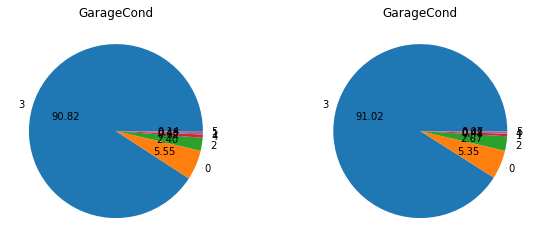

In [ ]:
print('Correlación: ', df_train['GarageCond']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["GarageCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="GarageCond")
df_test["GarageCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="GarageCond")

In [ ]:
# BsmtQual: Evaluates the height of the basement
BsmtQual = {}
BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
BsmtQual['Po'] = 1 #'Poor (<70 inches'
BsmtQual['No_Basement'] = 0 #'No Basement'

df_train.BsmtQual = df_train.BsmtQual.map(BsmtQual)
df_test.BsmtQual = df_test.BsmtQual.map(BsmtQual)
print('cat', df_train['BsmtQual'].unique())
print('test', df_test['BsmtQual'].unique())
list_var_cat.append('BsmtQual')

cat [4 3 5 0 2]
test [3 4 5 2 0]


Correlación:  0.5852071991725198


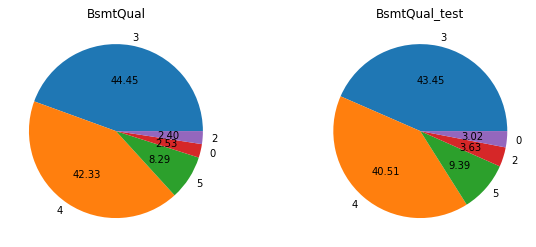

In [ ]:
print('Correlación: ', df_train['BsmtQual']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["BsmtQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="BsmtQual")
df_test["BsmtQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="BsmtQual_test")

In [ ]:
# BsmtCond: Evaluates the general condition of the basement
BsmtCond = {}
BsmtCond['Ex'] = 5 #'Excellent (100+ inches)'
BsmtCond['Gd'] = 4 #'Good (90-99 inches)'
BsmtCond['TA'] = 3 #'Typical (80-89 inches)'
BsmtCond['Fa'] = 2 #'Fair (70-79 inches)'
BsmtCond['Po'] = 1 #'Poor (<70 inches'
BsmtCond['No_Basement'] = 0 #'No Basement'

df_train.BsmtCond = df_train.BsmtCond.map(BsmtCond)
df_test.BsmtCond = df_test.BsmtCond.map(BsmtCond)
print('train', df_train['BsmtCond'].unique())
print('test', df_test['BsmtCond'].unique())
list_var_cat.append('BsmtCond')

train [3 4 0 2 1]
test [3 1 2 4 0]


Correlación:  0.21260715648557926


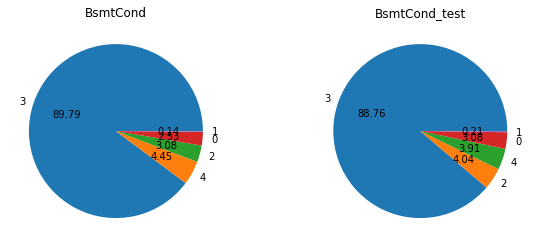

In [ ]:
print('Correlación: ', df_train['BsmtCond']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["BsmtCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="BsmtCond")
df_test["BsmtCond"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="BsmtCond_test")

In [ ]:
# GarageQual: Garage quality
GarageQual = {}
GarageQual['Ex'] = 5 #'Excellent 
GarageQual['Gd'] = 4 #'Good 
GarageQual['TA'] = 3 #'Typical 
GarageQual['Fa'] = 2 #'Fair 
GarageQual['Po'] = 1 #'Poor 
GarageQual['No_Garage'] = 0 #'No Garage'

df_train.GarageQual = df_train.GarageQual.map(GarageQual)
df_test.GarageQual = df_test.GarageQual.map(GarageQual)
print('cat', df_train['GarageQual'].unique())
print('test', df_test['GarageQual'].unique())
list_var_cat.append('GarageQual')

cat [3 2 4 0 5 1]
test [3 0 2 4 1]


Correlación:  0.273839074006224


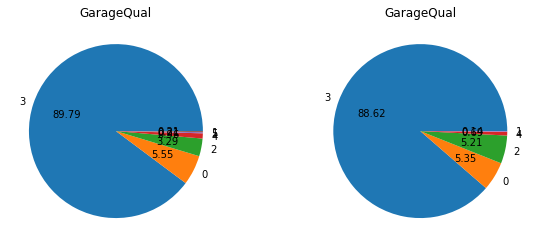

In [ ]:
print('Correlación: ', df_train['GarageQual']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["GarageQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="GarageQual")
df_test["GarageQual"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="GarageQual")

In [ ]:
# PoolQC: Pool quality
PoolQC = {}
PoolQC['Ex'] = 4 #'Excellent 
PoolQC['Gd'] = 3 #'Good 
PoolQC['TA'] = 2 #'Typical 
PoolQC['Fa'] = 1 #'Fair 
PoolQC['No_Pool'] = 0 #'No Pool'

df_train.PoolQC = df_train.PoolQC.map(PoolQC)
df_test.PoolQC = df_test.PoolQC.map(PoolQC)
print('train', df_train['PoolQC'].unique())
print('test', df_test['PoolQC'].unique())
list_var_cat.append('PoolQC')

train [0 4 1 3]
test [0 4 3]


Correlación:  0.11548430473054794


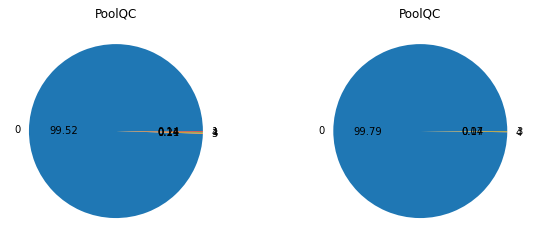

In [ ]:
print('Correlación: ', df_train['PoolQC']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["PoolQC"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="PoolQC")
df_test["PoolQC"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="PoolQC")

In [ ]:
# BsmtExposure: Refers to walkout or garden level walls
BsmtExposure = {}
BsmtExposure['Gd'] = 4 #'Good Exposure'
BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
BsmtExposure['No'] = 1 #'No Exposure'
BsmtExposure['No_Basement'] = 0 #'No Basement'

df_train.BsmtExposure = df_train.BsmtExposure.map(BsmtExposure)
df_test.BsmtExposure = df_test.BsmtExposure.map(BsmtExposure)
print('train', df_train['BsmtExposure'].unique())
print('test', df_test['BsmtExposure'].unique())
list_var_cat.append('BsmtExposure')

train [1 4 2 3 0]
test [1 4 2 3 0]


Correlación:  0.374696221000887


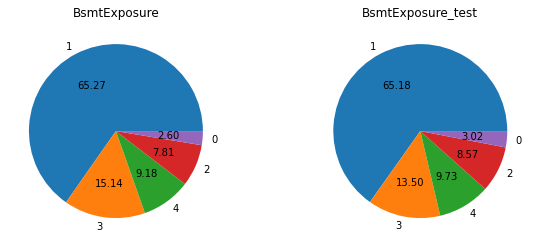

In [ ]:
print('Correlación: ', df_train['BsmtExposure']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["BsmtExposure"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="BsmtExposure")
df_test["BsmtExposure"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="BsmtExposure_test")

In [ ]:
# BsmtFinType1: Rating of basement finished area
BsmtFinType1 = {}
BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
BsmtFinType1['LwQ'] = 2 # 'Low Quality'
BsmtFinType1['Unf'] = 1 # 'Unfinshed'
BsmtFinType1['No_Basement'] = 0 #'No Basement'

df_train.BsmtFinType1 = df_train.BsmtFinType1.map(BsmtFinType1)
df_test.BsmtFinType1 = df_test.BsmtFinType1.map(BsmtFinType1)
print('train', df_train['BsmtFinType1'].unique())
print('test', df_test['BsmtFinType1'].unique())
list_var_cat.append('BsmtFinType1')

train [6 5 1 3 4 0 2]
test [3 5 6 1 4 2 0]


Correlación:  0.30490787307063294


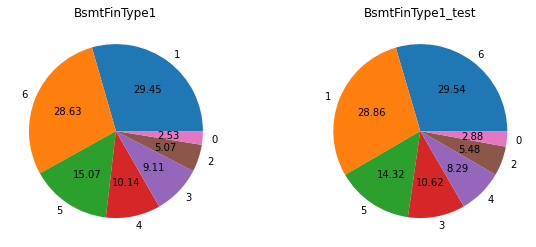

In [ ]:
print('Correlación: ', df_train['BsmtFinType1']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["BsmtFinType1"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="BsmtFinType1")
df_test["BsmtFinType1"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="BsmtFinType1_test")

In [ ]:
#BsmtFinType2: Rating of basement finished area (if multiple types)
BsmtFinType2 = {}
BsmtFinType2['GLQ'] = 6 #'Good Living Quarters'
BsmtFinType2['ALQ'] = 5 # 'Average Living Quarters'
BsmtFinType2['BLQ'] = 4 # 'Below Average Living Quarters'
BsmtFinType2['Rec'] = 3 # 'Average Rec Room'
BsmtFinType2['LwQ'] = 2 # 'Low Quality'
BsmtFinType2['Unf'] = 1 # 'Unfinshed'
BsmtFinType2['No_Basement'] = 0 #'No Basement'

df_train.BsmtFinType2 = df_train.BsmtFinType2.map(BsmtFinType2)
df_test.BsmtFinType2 = df_test.BsmtFinType2.map(BsmtFinType2)
print('train', df_train['BsmtFinType2'].unique())
print('test', df_test['BsmtFinType2'].unique())
list_var_cat.append('BsmtFinType2')

train [1 4 0 5 3 2 6]
test [2 1 3 4 6 5 0]


Correlación:  -0.005323160673474955


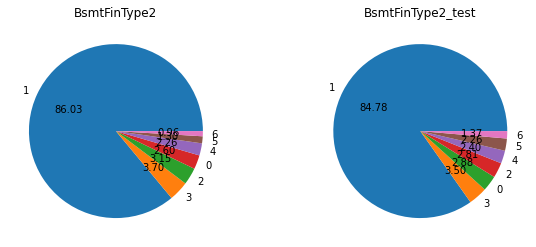

In [ ]:
print('Correlación: ', df_train['BsmtFinType2']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["BsmtFinType2"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="BsmtFinType2")
df_test["BsmtFinType2"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="BsmtFinType2_test")

In [ ]:
# PavedDrive: Paved driveway
PavedDrive = {}
PavedDrive['Y'] = 3 #'Paved'
PavedDrive['P'] = 2 #'Partial Pavement'
PavedDrive['N'] = 1 #'Dirt/Gravel'

df_train.PavedDrive = df_train.PavedDrive.map(PavedDrive)
df_test.PavedDrive = df_test.PavedDrive.map(PavedDrive)
print('train', df_train['PavedDrive'].unique())
print('test', df_test1['PavedDrive'].unique())
list_var_cat.append('PavedDrive')

train [3 1 2]
test ['Y' 'N' 'P']


Correlación:  0.23135695225722677


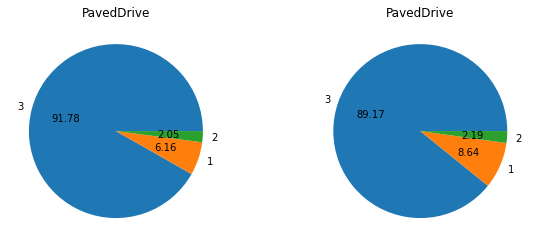

In [ ]:
print('Correlación: ', df_train['PavedDrive']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["PavedDrive"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="PavedDrive")
df_test["PavedDrive"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="PavedDrive")

In [ ]:
# LandSlope: Slope of property
LandSlope = {}
LandSlope['Gtl'] = 3 #'Gentle slope'
LandSlope['Mod'] = 2 #'Moderate Slope'
LandSlope['Sev'] = 1 #'Severe Slope'

df_train.LandSlope = df_train.LandSlope.map(LandSlope)
df_test.LandSlope = df_test.LandSlope.map(LandSlope)
print('train', df_train['LandSlope'].unique())
print('test', df_test['LandSlope'].unique())
list_var_cat.append('LandSlope')

train [3 2 1]
test [3 2 1]


Correlación:  -0.051152248179466564


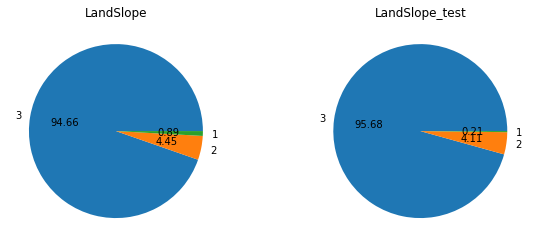

In [ ]:
print('Correlación: ', df_train['LandSlope']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["LandSlope"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="LandSlope")
df_test["LandSlope"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="LandSlope_test")

In [ ]:
# LotShape: General shape of property
LotShape = {}
LotShape['Reg'] = 4 #'Regular'
LotShape['IR1'] = 3 #'Slightly irregular'
LotShape['IR2'] = 2 #'Moderately Irregular'
LotShape['IR3'] = 1 #'Irregular'

df_train.LotShape = df_train.LotShape.map(LotShape)
df_test.LotShape = df_test.LotShape.map(LotShape)
print('train', df_train['LotShape'].unique())
print('test', df_test['LotShape'].unique())
list_var_cat.append('LotShape')

train [4 3 2 1]
test [4 3 2 1]


Correlación:  -0.26775931391782376


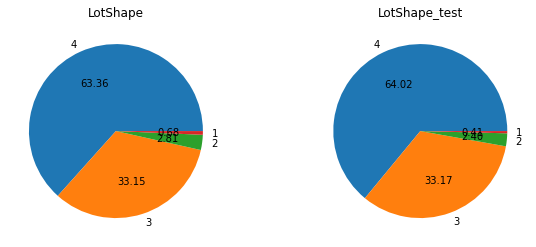

In [ ]:
print('Correlación: ', df_train['LotShape']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["LotShape"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="LotShape")
df_test["LotShape"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="LotShape_test")

In [ ]:
# CentralAir: Central air conditioning
CentralAir = {}
CentralAir['N'] = 0
CentralAir['Y'] = 1

df_train.CentralAir = df_train.CentralAir.map(CentralAir)
df_test.CentralAir = df_test.CentralAir.map(CentralAir)
print('train', df_train['CentralAir'].unique())
print('test', df_test['CentralAir'].unique())
list_var_cat.append('CentralAir')

train [1 0]
test [1 0]


Correlación:  0.25132816384015527


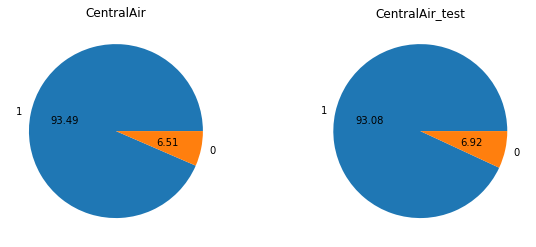

In [ ]:
print('Correlación: ', df_train['CentralAir']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["CentralAir"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="CentralAir")
df_test["CentralAir"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="CentralAir_test")

In [ ]:
# GarageFinish: Interior finish of the garage
GarageFinish = {}
GarageFinish['Fin'] = 3 #'Finished'
GarageFinish['RFn'] = 2 #'Rough Finished'
GarageFinish['Unf'] = 1 #'Unfinished'
GarageFinish['No_Garage'] = 0 #'No Garage'

df_train.GarageFinish = df_train.GarageFinish.map(GarageFinish)
df_test.GarageFinish = df_test.GarageFinish.map(GarageFinish)
print('train', df_train['GarageFinish'].unique())
print('test', df_test['GarageFinish'].unique())
list_var_cat.append('GarageFinish')

train [2 1 3 0]
test [1 3 2 0]


Correlación:  0.5492467563332117


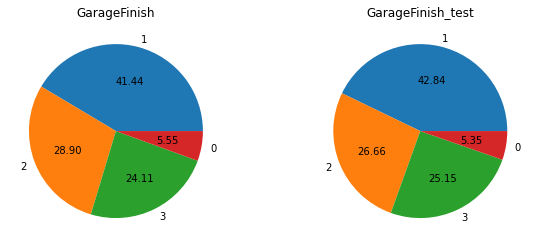

In [ ]:
print('Correlación: ', df_train['GarageFinish']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["GarageFinish"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="GarageFinish")
df_test["GarageFinish"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="GarageFinish_test")

In [ ]:
# Functional: Home functionality
Functional = {}
Functional['Typ'] = 7   # Typical Functionality
Functional['Min1'] = 6  # Minor Deductions 1
Functional['Min2'] = 5  # Minor Deductions 2
Functional['Mod'] = 4   # Moderate Deductions
Functional['Maj1'] = 3  # Major Deductions 1
Functional['Maj2'] = 2  # Major Deductions 2
Functional['Sev'] = 1   # Severely Damaged
Functional['Sal'] = 0   # Salvage only

df_train.Functional = df_train.Functional.map(Functional)
df_test.Functional = df_test.Functional.map(Functional)
print('train', df_train['Functional'].unique())
print('test', df_test['Functional'].unique())
list_var_cat.append('Functional')

train [7 6 3 5 4 2 1]
test [7 5 6 4 3 1 2]


Correlación:  0.10761889324399447


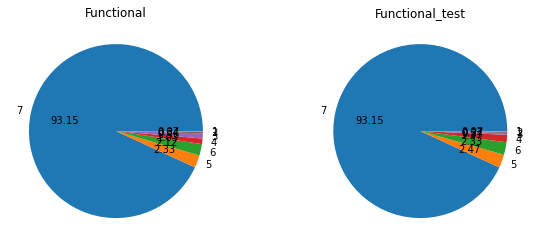

In [ ]:
print('Correlación: ', df_train['Functional']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["Functional"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="Functional")
df_test["Functional"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="Functional_test")

In [ ]:
# Street: Type of road access to property
Street = {}
Street['Grvl'] = 0 # Gravel 
Street['Pave'] = 1 # Paved

df_train.Street = df_train.Street.map(Street)
df_test.Street = df_test.Street.map(Street)
print('train', df_train['Street'].unique())
print('test', df_test['Street'].unique())
list_var_cat.append('Street')

train [1 0]
test [1 0]


Correlación:  0.04103553550004948


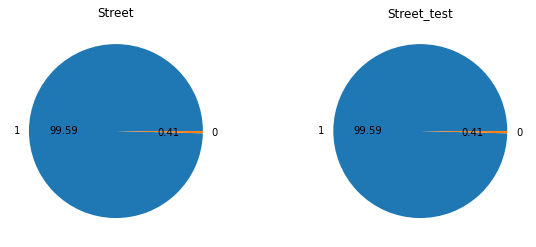

In [ ]:
print('Correlación: ', df_train['Street']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["Street"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="Street")
df_test["Street"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="Street_test")

In [ ]:
 # Fence: Fence quality
Fence = {}
Fence['GdPrv'] = 4 #'Good Privacy'
Fence['MnPrv'] = 3 #'Minimum Privacy'
Fence['GdWo'] = 2 #'Good Wood'
Fence['MnWw'] = 1 #'Minimum Wood/Wire'
Fence['No_Fence'] = 0 #'No Fence'

df_train.Fence = df_train.Fence.map(Fence)
df_test.Fence = df_test.Fence.map(Fence)
print('train', df_train['Fence'].unique())
print('test', df_test['Fence'].unique())
list_var_cat.append('Fence')

train [0 3 2 4 1]
test [3 0 4 2 1]


Correlación:  -0.14694152643588418


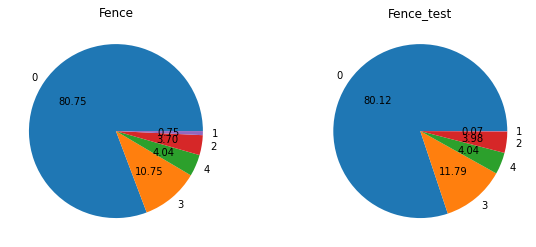

In [ ]:
print('Correlación: ', df_train['Fence']. corr (df_train['SalePrice']))
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
df_train["Fence"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[0], title="Fence")
df_test["Fence"].value_counts().rename("").plot.pie(autopct='%.2f', ax=ax[1], title="Fence_test")

In [ ]:
print(list_var_cat)

['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageCond', 'BsmtQual', 'BsmtCond', 'GarageQual', 'PoolQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PavedDrive', 'LandSlope', 'LotShape', 'CentralAir', 'GarageFinish', 'Functional', 'Street', 'Fence']


In [ ]:
dict_corr_cat = {}
for x in list_var_cat:
    corr = df_train[x].corr(df_train['SalePrice'])
    dict_corr_cat[x] = corr
dict_corr_cat = sorted(dict_corr_cat.items(), key=operator.itemgetter(1), reverse=True)
dict_corr_cat

[('ExterQual', 0.6826392416562594),
 ('KitchenQual', 0.6595997207286639),
 ('BsmtQual', 0.5852071991725198),
 ('GarageFinish', 0.5492467563332117),
 ('FireplaceQu', 0.5204376059504016),
 ('HeatingQC', 0.427648707398804),
 ('BsmtExposure', 0.374696221000887),
 ('BsmtFinType1', 0.30490787307063294),
 ('GarageQual', 0.273839074006224),
 ('GarageCond', 0.263190784470399),
 ('CentralAir', 0.25132816384015527),
 ('PavedDrive', 0.23135695225722677),
 ('BsmtCond', 0.21260715648557926),
 ('PoolQC', 0.11548430473054794),
 ('Functional', 0.10761889324399447),
 ('Street', 0.04103553550004948),
 ('ExterCond', 0.018899118482413015),
 ('BsmtFinType2', -0.005323160673474955),
 ('LandSlope', -0.051152248179466564),
 ('Fence', -0.14694152643588418),
 ('LotShape', -0.26775931391782376)]

In [ ]:
# Se borran las columnas categoricas con menos correlación con la variable objetivo
#var_cat_poca_corr = ['LandSlope', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition']
var_cat_poca_corr = ['LotShape', 'Fence', 'LandSlope', 'BsmtFinType2', 'ExterCond', 'Street', 'Functional', 'PoolQC']

df_train = df_train.drop(var_cat_poca_corr, axis=1)    
df_test = df_test.drop(var_cat_poca_corr, axis=1)    
print('train', df_train.shape)
print('test', df_test.shape)

train (1460, 72)
test (1459, 71)


In [ ]:
# Se obtienen las columnas con varibles categoricas que todavía quedan sin convertir
cat_OHE_vars = [var for var in df_train.columns if df_train[var].dtypes == 'O']

print('Number of categorical variables: ', len(cat_OHE_vars))
print(cat_OHE_vars)

Number of categorical variables:  24
['MSSubClass', 'MSZoning', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


### Variables categóricas con OneHotEncoder()

In [ ]:
df_cat_OHE = pd.DataFrame()
df_test_OHE = pd.DataFrame()
for x in cat_OHE_vars:
    df_cat_OHE[x] = df_train[x]
    df_test_OHE[x] = df_train[x]
df_cat_OHE.head()

MSSubClass MSZoning     Alley LandContour Utilities LotConfig Neighborhood  \
0         60       RL  No_Alley         Lvl    AllPub    Inside      CollgCr   
1         20       RL  No_Alley         Lvl    AllPub       FR2      Veenker   
2         60       RL  No_Alley         Lvl    AllPub    Inside      CollgCr   
3         70       RL  No_Alley         Lvl    AllPub    Corner      Crawfor   
4         60       RL  No_Alley         Lvl    AllPub       FR2      NoRidge   

  Condition1 Condition2 BldgType  ... Exterior2nd MasVnrType Foundation  \
0       Norm       Norm     1Fam  ...     VinylSd    BrkFace      PConc   
1      Feedr       Norm     1Fam  ...     MetalSd       None     CBlock   
2       Norm       Norm     1Fam  ...     VinylSd    BrkFace      PConc   
3       Norm       Norm     1Fam  ...     Wd Shng       None     BrkTil   
4       Norm       Norm     1Fam  ...     VinylSd    BrkFace      PConc   

  Heating Electrical GarageType MiscFeature MoSold SaleType SaleCondition  
0    GasA      SBrkr     Attchd        None      2       WD        Normal  
1    GasA      SBrkr     Attchd        None      5       WD        Normal  
2    GasA      SBrkr     Attchd        None      9       WD        Normal  
3    GasA      SBrkr     Detchd        None      2       WD       Abnorml  
4    GasA      SBrkr     Attchd        None     12       WD        Normal  

[5 rows x 24 columns]

In [ ]:
y_SalePrice = df_train['SalePrice']
df_train = df_train.drop('SalePrice', axis=1)

ohencoder = ce.OneHotEncoder(cols=cat_OHE_vars, use_cat_names=True)

df_train = ohencoder.fit_transform(df_train)
df_test = ohencoder.transform(df_test)
df_train['SalePrice'] = y_SalePrice
print('train: ', df_train.shape)
print('test', df_test.shape)

train:  (1460, 242)
test (1459, 241)


In [ ]:
# Se cuentan las colunmas con pocas apariciones
cont = 0
list_poca_apa = []
y_col = df_train['SalePrice']
df_train = df_train.drop(['SalePrice'], axis=1)
for x in df_train.columns:
    if (df_train[x].sum()<42) & (df_test[x].sum()<42):
        cont = cont + 1
        list_poca_apa.append(x)
print(cont)
print(list_poca_apa)
df_train['SalePrice'] = y_col

95
['MSSubClass_190', 'MSSubClass_45', 'MSSubClass_85', 'MSSubClass_75', 'MSSubClass_180', 'MSSubClass_40', 'MSZoning_C (all)', 'MSZoning_RH', 'Alley_Pave', 'LandContour_Low', 'Utilities_NoSeWa', 'LotConfig_FR3', 'Neighborhood_Veenker', 'Neighborhood_NoRidge', 'Neighborhood_MeadowV', 'Neighborhood_Timber', 'Neighborhood_StoneBr', 'Neighborhood_ClearCr', 'Neighborhood_NPkVill', 'Neighborhood_Blmngtn', 'Neighborhood_BrDale', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRNn', 'Condition1_RRAn', 'Condition1_PosA', 'Condition1_RRNe', 'Condition2_Artery', 'Condition2_RRNn', 'Condition2_Feedr', 'Condition2_PosN', 'Condition2_PosA', 'Condition2_RRAn', 'Condition2_RRAe', 'BldgType_2fmCon', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Unf', 'HouseStyle_2.5Fin', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Flat', 'RoofStyle_Shed', 'RoofMatl_WdShngl', 'RoofMatl_Metal', 'RoofMatl_WdShake', 'RoofMatl_Membran', 'RoofMatl_Tar&Grv', 'RoofMatl_Roll', 'R

In [ ]:
# Se borran las variables con pocas apariciones
for x in list_poca_apa:
    df_train = df_train.drop(x, axis=1)
    df_test = df_test.drop(x, axis=1)

# VARIABLES NUMÉRICAS

### Se buscan las correlaciones de las columnas numéricas con la variable objetivo

In [ ]:
df_num = pd.DataFrame()
for x in num_vars:
    df_num[x] = df_train[x]
df_num.head(3)

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0         65.0     8450            7            5       2003          2003   
1         80.0     9600            6            8       1976          1976   
2         68.0    11250            7            5       2001          2002   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  GarageArea  WoodDeckSF  \
0       196.0         706           0        150  ...         548           0   
1         0.0         978           0        284  ...         460         298   
2       162.0         486           0        434  ...         608           0   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0           61              0          0            0         0        0   
1            0              0          0            0         0        0   
2           42              0          0            0         0        0   

   YrSold  SalePrice  
0    2008     208500  
1    2007     181500  
2    2008     223500  

[3 rows x 35 columns]

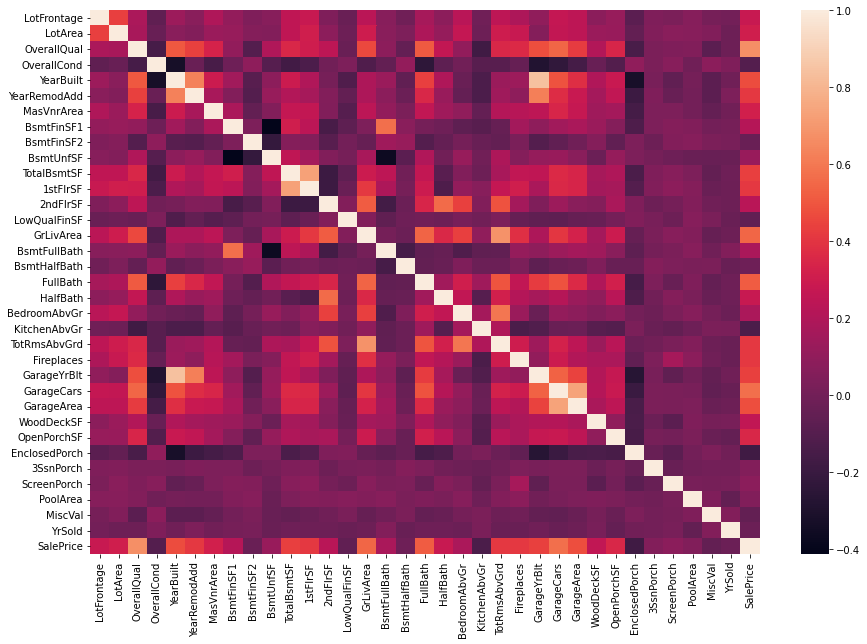

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(df_num.corr(method='kendall'), ax=ax)

In [ ]:
# Características de las variables numéricas
display(df_num.describe().transpose())

count           mean           std      min        25%  \
LotFrontage    1460.0      70.049958     22.024023     21.0      60.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1460.0     103.117123    180.731373      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1460.0    1976.507534     26.306739   1872.0    1959.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                         50%        75%       max  
LotFrontage        70.049958      79.00     313.0  
LotArea          9478.500000   11601.50  215245.0  
OverallQual         6.000000       7.00      10.0  
OverallCond         5.000000       6.00       9.0  
YearBuilt        1973.000000    2000.00    2010.0  
YearRemodAdd     1994.000000    2004.00    2010.0  
MasVnrArea          0.000000     164.25    1600.0  
BsmtFinSF1        383.500000     712.25    5644.0  
BsmtFinSF2          0.000000       0.00    1474.0  
BsmtUnfSF         477.500000     808.00    2336.0  
TotalBsmtSF       991.500000    1298.25    6110.0  
1stFlrSF         1087.000000    1391.25    4692.0  
2ndFlrSF            0.000000     728.00    2065.0  
LowQualFinSF        0.000000       0.00     572.0  
GrLivArea        1464.000000    1776.75    5642.0  
BsmtFullBath        0.000000       1.00       3.0  
BsmtHalfBath        0.000000       0.00       2.0  
FullBath            2.000000       2.00       3.0  
HalfBath            0.000000       1.00       2.0  
BedroomAbvGr        3.000000       3.00       8.0  
KitchenAbvGr        1.000000       1.00       3.0  
TotRmsAbvGrd        6.000000       7.00      14.0  
Fireplaces          1.000000       1.00       3.0  
GarageYrBlt      1978.000000    2001.00    2010.0  
GarageCars          2.000000       2.00       4.0  

In [ ]:
# Se crea un diccionario con las correlaciones entre las variables independientes y la variable objetivo
dict_corr = {}
for x in num_vars:
    corr = df_num[x].corr(df_num['SalePrice'])
    dict_corr[x] = corr
dict_corr = sorted(dict_corr.items(), key=operator.itemgetter(1), reverse=True)
dict_corr 

[('SalePrice', 1.0),
 ('OverallQual', 0.7909816005838044),
 ('GrLivArea', 0.7086244776126523),
 ('GarageCars', 0.6404091972583529),
 ('GarageArea', 0.6234314389183618),
 ('TotalBsmtSF', 0.6135805515591956),
 ('1stFlrSF', 0.6058521846919147),
 ('FullBath', 0.5606637627484449),
 ('TotRmsAbvGrd', 0.5337231555820282),
 ('YearBuilt', 0.5228973328794969),
 ('GarageYrBlt', 0.508043287161516),
 ('YearRemodAdd', 0.5071009671113865),
 ('MasVnrArea', 0.47261449900457475),
 ('Fireplaces', 0.46692883675152724),
 ('BsmtFinSF1', 0.3864198062421532),
 ('LotFrontage', 0.3349008515405508),
 ('WoodDeckSF', 0.3244134445681294),
 ('2ndFlrSF', 0.3193338028320681),
 ('OpenPorchSF', 0.3158562271160555),
 ('HalfBath', 0.2841076755947831),
 ('LotArea', 0.2638433538714056),
 ('BsmtFullBath', 0.22712223313149382),
 ('BsmtUnfSF', 0.21447910554696892),
 ('BedroomAbvGr', 0.16821315430073988),
 ('ScreenPorch', 0.11144657114291105),
 ('PoolArea', 0.09240354949187321),
 ('3SsnPorch', 0.04458366533574846),
 ('BsmtFinSF2

### Columnas Numéricas vs Variable objetivo

Correlación:  0.7909816005838044


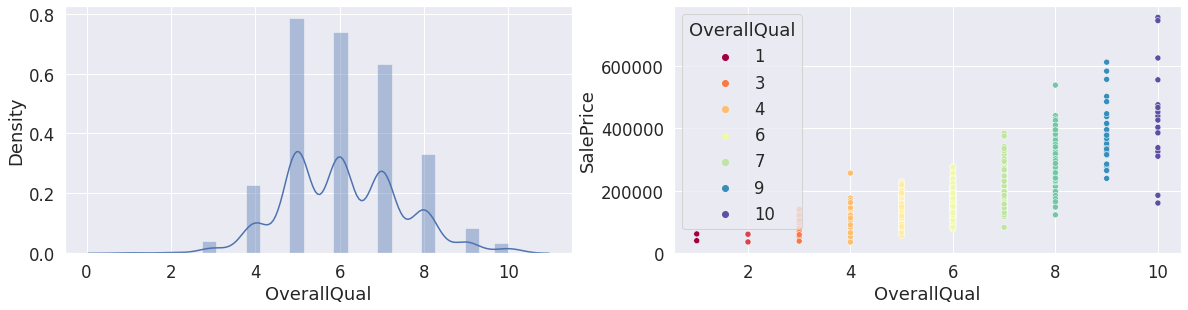

In [ ]:
# OverallQual: Rates the overall material and finish of the house
print('Correlación: ', df_train['OverallQual']. corr (df_train['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
#sns.boxplot(x='OverallQual', y='SalePrice', data=df_num[['SalePrice', 'OverallQual']])
sns.distplot(df_train['OverallQual'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_train.OverallQual, y = df_train.SalePrice, hue=df_train.OverallQual, palette= 'Spectral')

Correlación:  0.7086244776126523


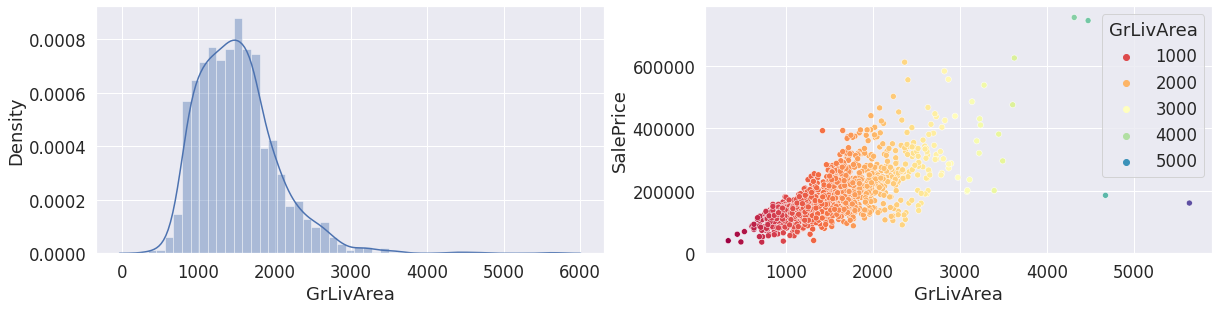

In [ ]:
# GrLivArea: Above grade (ground) living area square feet
print('Correlación: ', df_train['GrLivArea']. corr (df_train['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
# sns.boxplot(x='GrLivArea', y='SalePrice', data=df_num[['SalePrice', 'GrLivArea']])
sns.distplot(df_train['GrLivArea'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_train.GrLivArea, y = df_train.SalePrice, hue=df_train.GrLivArea, palette= 'Spectral')

Correlación:  0.6953642208523488


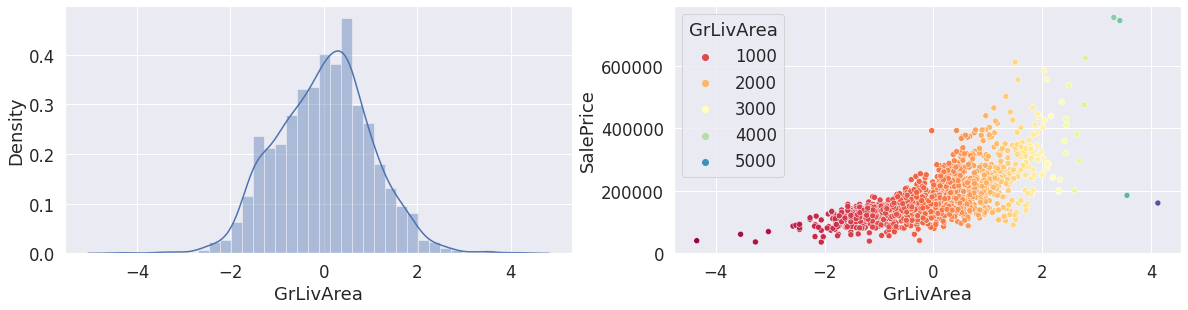

In [ ]:
# GrLivArea: Above grade (ground) living area square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='box-cox')
# Normalizamos usando Box-Cox
normalized = pt.fit_transform(df_train[['GrLivArea']])
normalized_test = pt.transform(df_test[['GrLivArea']])
df_normalized = pd.DataFrame(normalized, columns=['GrLivArea'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['GrLivArea'])

print('Correlación: ', df_normalized['GrLivArea']. corr (df_train['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['GrLivArea'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['GrLivArea'], y = df_train.SalePrice, hue=df_train.GrLivArea, palette= 'Spectral')

df_train['GrLivArea'] = df_normalized['GrLivArea']
df_test['GrLivArea'] = df_normalized_test['GrLivArea']

Correlación:  0.6404091972583529


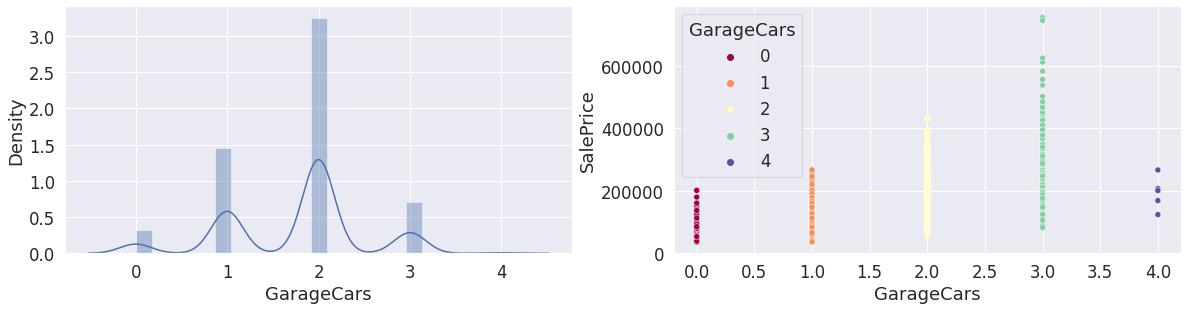

In [ ]:
# GarageCars: Size of garage in car capacity
print('Correlación: ', df_train['GarageCars']. corr (df_train['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_train['GarageCars'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_train.GarageCars, y = df_train.SalePrice, hue=df_train.GarageCars, palette= 'Spectral')

Correlación:  0.6234314389183618


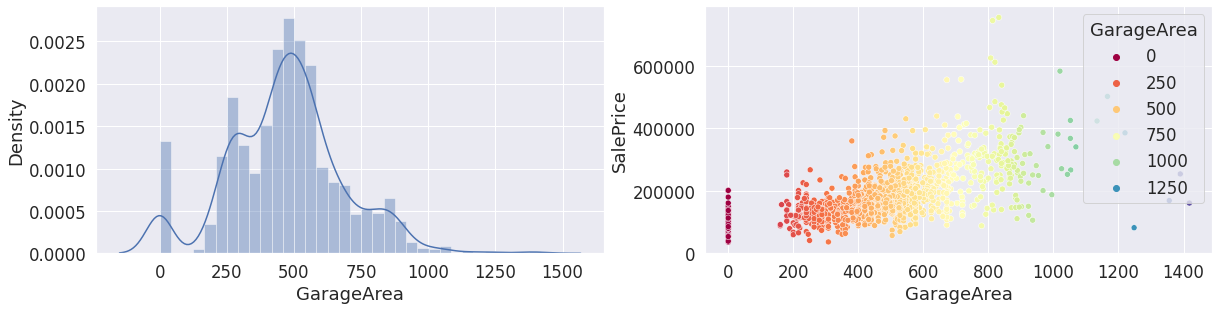

In [ ]:
# GarageArea: Size of garage in square feet
print('Correlación: ', df_train['GarageArea']. corr (df_train['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_train['GarageArea'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_train.GarageArea, y = df_train.SalePrice, hue=df_train.GarageArea, palette= 'Spectral')

In [ ]:
def Gar_category(cat):
    if cat <= 250:
        return 1
    elif cat <= 500 and cat > 250:
        return 2
    elif cat <= 1000 and cat > 500:
        return 3
    return 4

df_train['GarageArea_cat'] = df_train['GarageArea'].apply(Gar_category)
df_test['GarageArea_cat'] = df_test['GarageArea'].apply(Gar_category)
df_train = df_train.drop('GarageArea', axis=1)
df_test = df_test.drop('GarageArea', axis=1)

Correlación:  0.6135805515591956


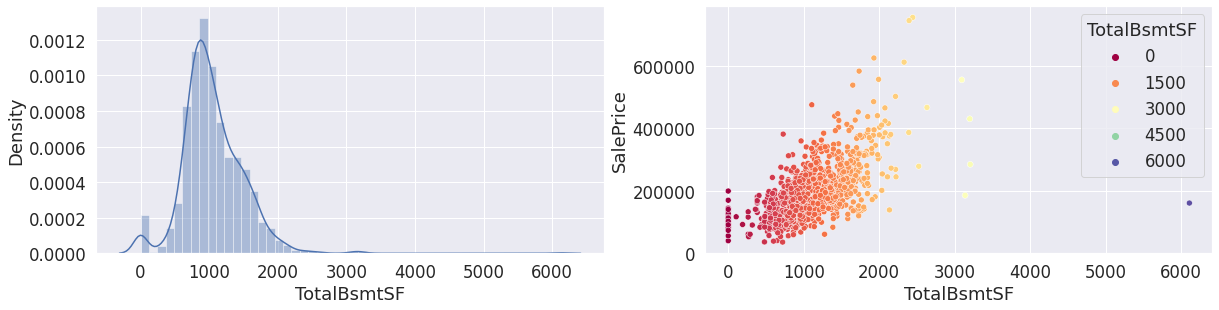

In [ ]:
# TotalBsmtSF: Total square feet of basement area
print('Correlación: ', df_num['TotalBsmtSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['TotalBsmtSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num.TotalBsmtSF, y = df_num.SalePrice, hue=df_num.TotalBsmtSF, palette= 'Spectral')

Correlación:  0.6014546730684436


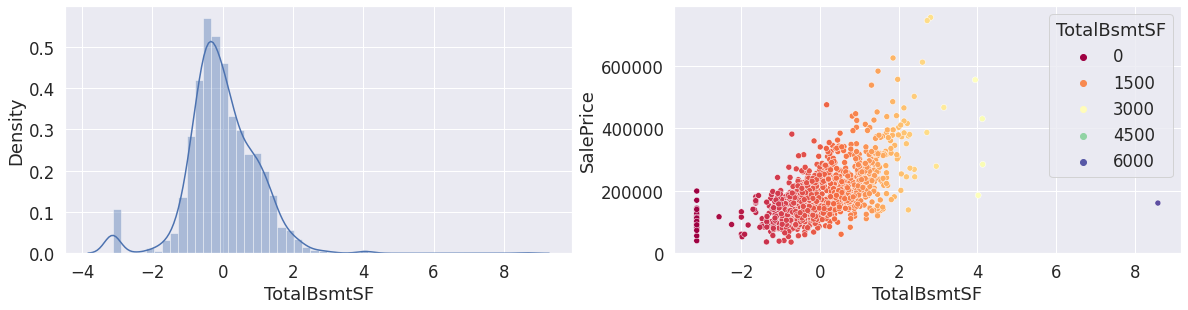

In [ ]:
# TotalBsmtSF: Total square feet of basement area
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['TotalBsmtSF']])
normalized_test = pt.transform(df_test[['TotalBsmtSF']])
df_normalized = pd.DataFrame(normalized, columns=['TotalBsmtSF'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['TotalBsmtSF'])

print('Correlación: ', df_normalized['TotalBsmtSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['TotalBsmtSF'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['TotalBsmtSF'], y = df_num.SalePrice, hue=df_num.TotalBsmtSF, palette= 'Spectral')

df_train['TotalBsmtSF'] = df_normalized['TotalBsmtSF']
df_test['TotalBsmtSF'] = df_normalized_test['TotalBsmtSF']

Correlación:  0.6058521846919147


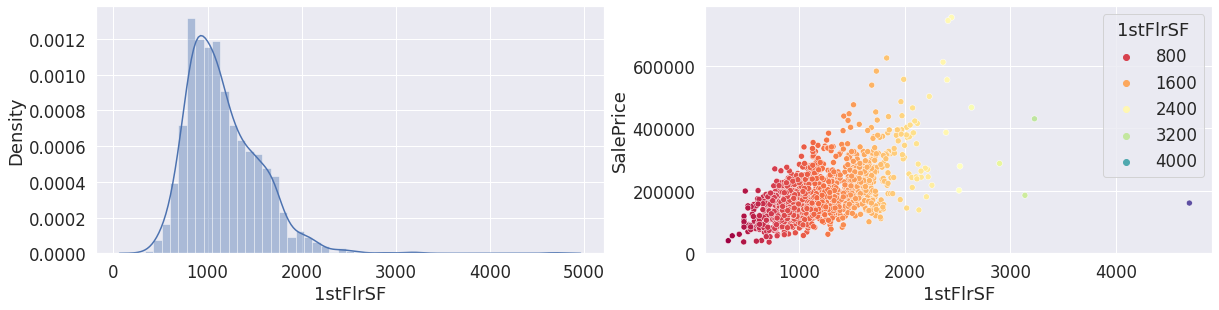

In [ ]:
# 1stFlrSF: First Floor square feet
print('Correlación: ', df_num['1stFlrSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['1stFlrSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['1stFlrSF'], y = df_num.SalePrice, hue=df_num['1stFlrSF'], palette= 'Spectral')

Correlación:  0.5882901851970442


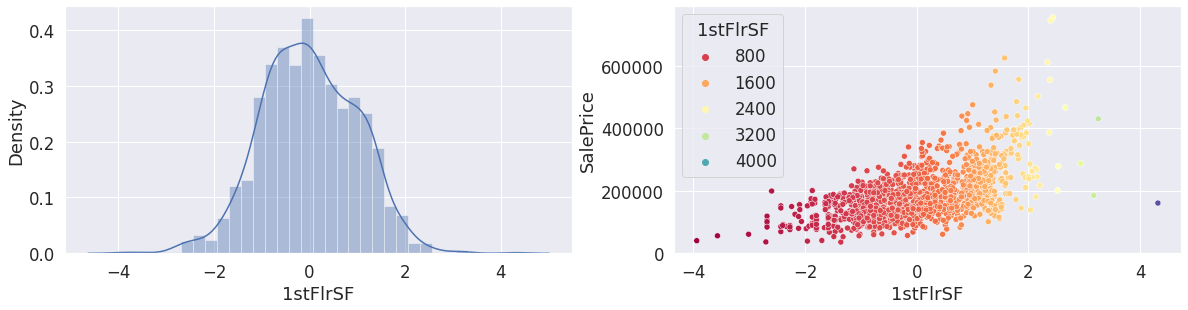

In [ ]:
# 1stFlrSF: First Floor square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='box-cox')
# Normalizamos usando Box-Cox
normalized = pt.fit_transform(df_train[['1stFlrSF']])
normalized_test = pt.transform(df_test[['1stFlrSF']])
df_normalized = pd.DataFrame(normalized, columns=['1stFlrSF'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['1stFlrSF'])

print('Correlación: ', df_normalized['1stFlrSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['1stFlrSF'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['1stFlrSF'], y = df_num.SalePrice, hue=df_num['1stFlrSF'], palette= 'Spectral')

df_train['1stFlrSF'] = df_normalized['1stFlrSF']
df_test['1stFlrSF'] = df_normalized_test['1stFlrSF']

Correlación:  0.5606637627484449


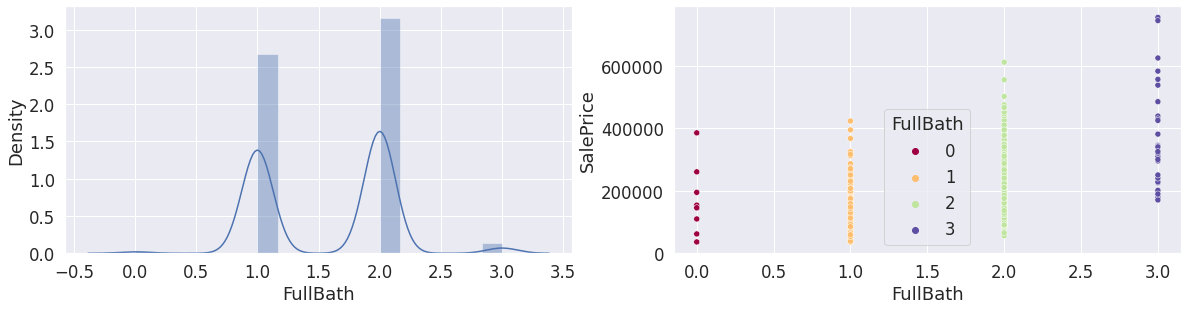

In [ ]:
# FullBath: Full bathrooms above grade
print('Correlación: ', df_num['FullBath']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
#sns.boxplot(x='FullBath', y='SalePrice', data=df_num[['SalePrice', 'FullBath']])
sns.distplot(df_num['FullBath'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['FullBath'], y = df_num.SalePrice, hue=df_num['FullBath'], palette= 'Spectral')

Correlación:  0.47261449900457475


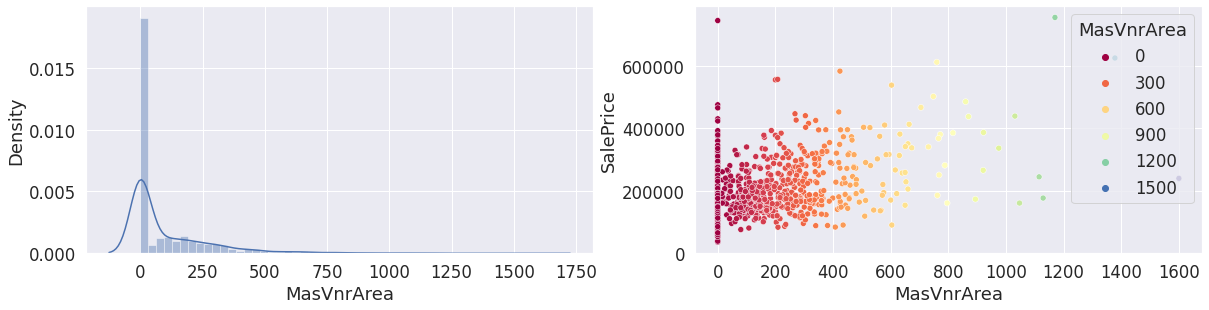

In [ ]:
# MasVnrArea: Masonry veneer area in square feet
print('Correlación: ', df_num['MasVnrArea']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['MasVnrArea'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['MasVnrArea'], y = df_num.SalePrice, hue=df_num['MasVnrArea'], palette= 'Spectral')

Correlación:  0.38424409377336655


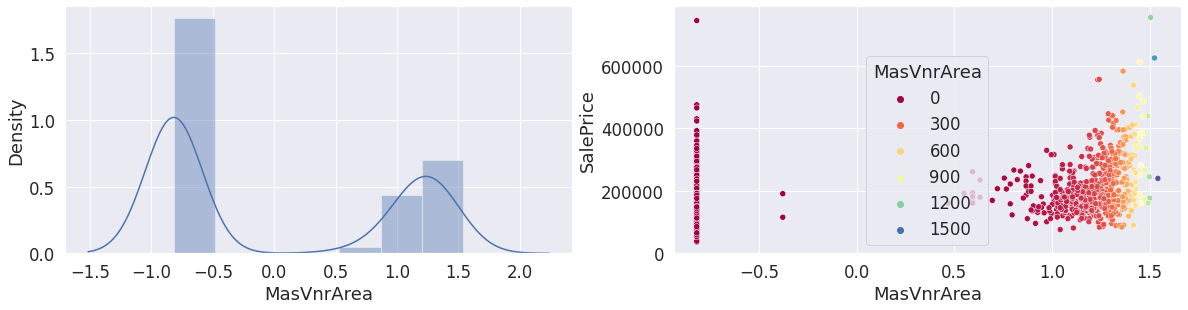

In [ ]:
# MasVnrArea: Masonry veneer area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['MasVnrArea']])
normalized_test = pt.transform(df_test[['MasVnrArea']])
df_normalized = pd.DataFrame(normalized, columns=['MasVnrArea'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['MasVnrArea'])

print('Correlación: ', df_normalized['MasVnrArea']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['MasVnrArea'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['MasVnrArea'], y = df_num.SalePrice, hue=df_num['MasVnrArea'], palette= 'Spectral')

df_train['MasVnrArea'] = df_normalized['MasVnrArea']
df_test['MasVnrArea'] = df_normalized_test['MasVnrArea']

Correlación:  0.46692883675152724


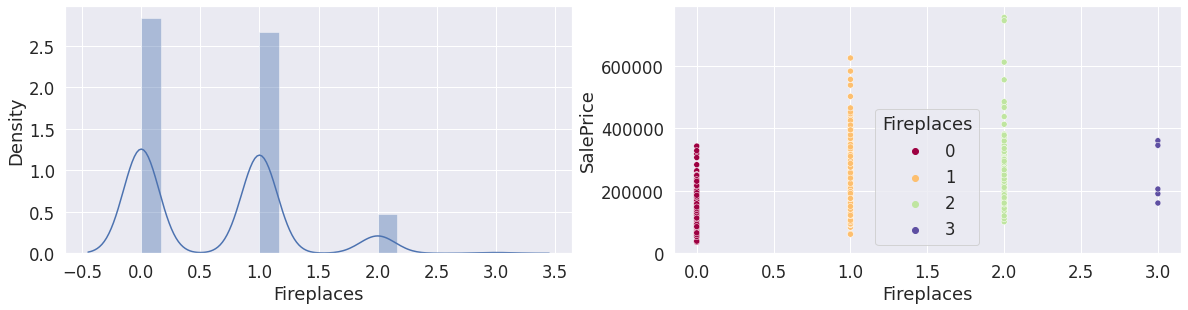

In [ ]:
# Fireplaces: Number of fireplaces
print('Correlación: ', df_num['Fireplaces']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['Fireplaces'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['Fireplaces'], y = df_num.SalePrice, hue=df_num['Fireplaces'], palette= 'Spectral')

Correlación:  0.3864198062421532


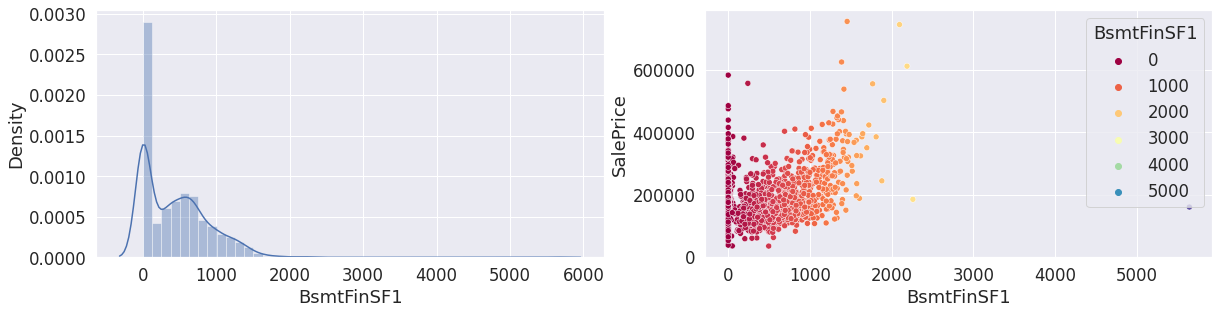

In [ ]:
# BsmtFinSF1: Type 1 finished square feet
print('Correlación: ', df_num['BsmtFinSF1']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BsmtFinSF1'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BsmtFinSF1'], y = df_num.SalePrice, hue=df_num['BsmtFinSF1'], palette= 'Spectral')

Correlación:  0.23265864536682043


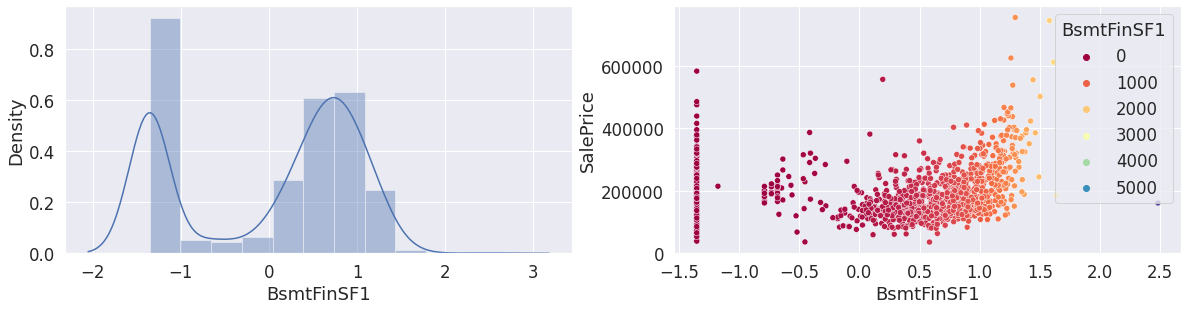

In [ ]:
# BsmtFinSF1: Type 1 finished square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['BsmtFinSF1']])
normalized_test = pt.transform(df_test[['BsmtFinSF1']])
df_normalized = pd.DataFrame(normalized, columns=['BsmtFinSF1'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['BsmtFinSF1'])

print('Correlación: ', df_normalized['BsmtFinSF1']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['BsmtFinSF1'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['BsmtFinSF1'], y = df_num.SalePrice, hue=df_num['BsmtFinSF1'], palette= 'Spectral')

df_train['BsmtFinSF1'] = df_normalized['BsmtFinSF1']
df_test['BsmtFinSF1'] = df_normalized_test['BsmtFinSF1']

Correlación:  0.3349008515405508


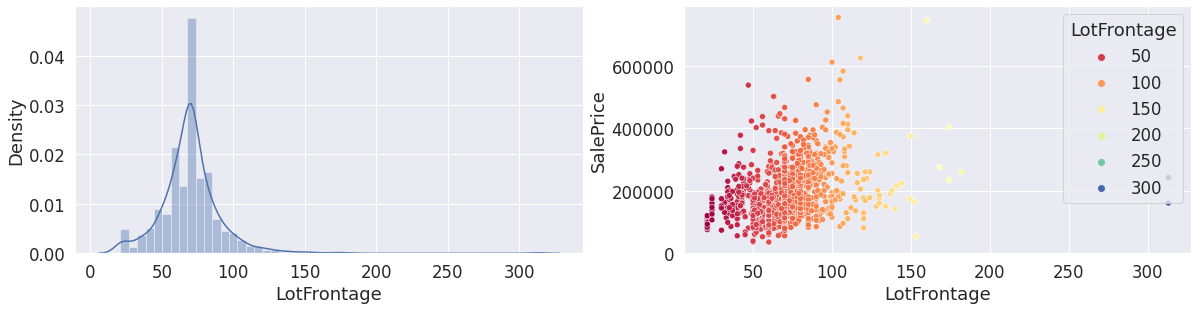

In [ ]:
# LotFrontage: Linear feet of street connected to property
print('Correlación: ', df_num['LotFrontage']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['LotFrontage'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['LotFrontage'], y = df_num.SalePrice, hue=df_num['LotFrontage'], palette= 'Spectral')

In [ ]:
df_train['LotFrontage'] = np.log1p(df_train['LotFrontage'])
df_test['LotFrontage'] = np.log1p(df_test['LotFrontage'])

Correlación:  0.3244134445681294


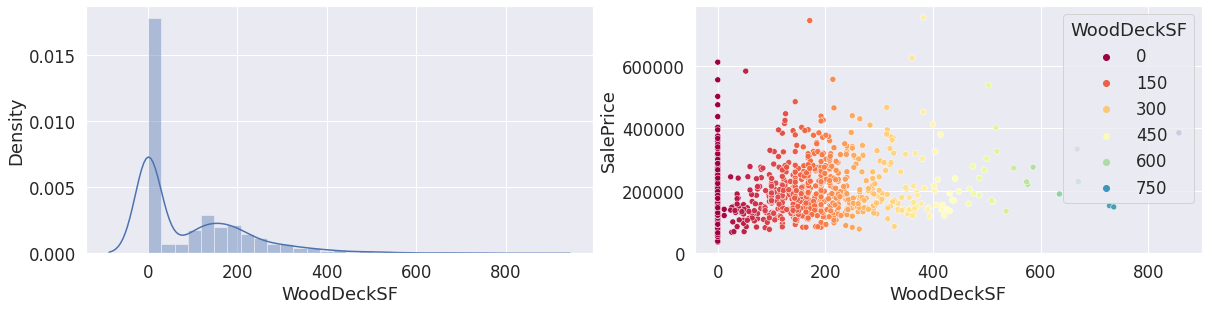

In [ ]:
# WoodDeckSF: Wood deck area in square feet
print('Correlación: ', df_num['WoodDeckSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['WoodDeckSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['WoodDeckSF'], y = df_num.SalePrice, hue=df_num['WoodDeckSF'], palette= 'Spectral')

Correlación:  0.31806648216433253


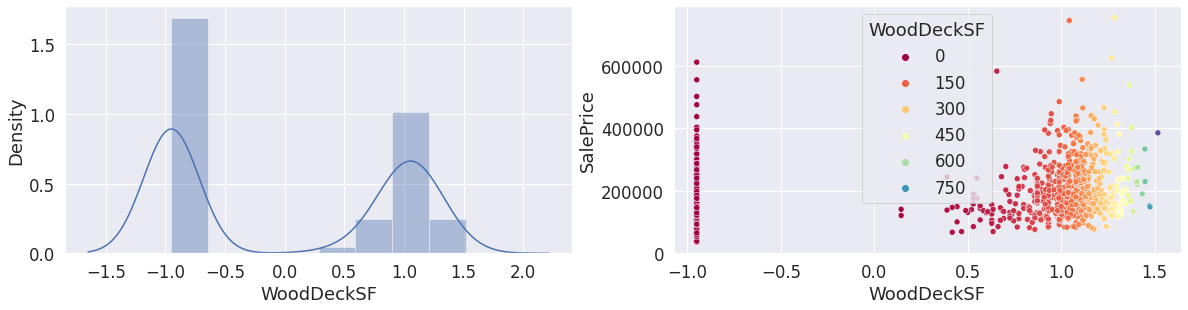

In [ ]:
# WoodDeckSF: Wood deck area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['WoodDeckSF']])
normalized_test = pt.transform(df_test[['WoodDeckSF']])
df_normalized = pd.DataFrame(normalized, columns=['WoodDeckSF'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['WoodDeckSF'])

print('Correlación: ', df_normalized['WoodDeckSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['WoodDeckSF'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['WoodDeckSF'], y = df_num.SalePrice, hue=df_num['WoodDeckSF'], palette= 'Spectral')

df_train['WoodDeckSF'] = df_normalized['WoodDeckSF']
df_test['WoodDeckSF'] = df_normalized_test['WoodDeckSF']

Correlación:  0.3193338028320681


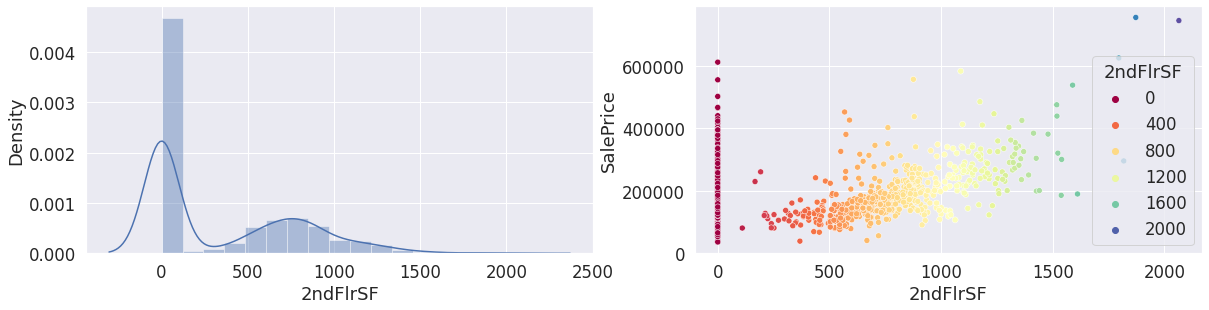

In [ ]:
# 2ndFlrSF: Second Floor square feet
print('Correlación: ', df_num['2ndFlrSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['2ndFlrSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['2ndFlrSF'], y = df_num.SalePrice, hue=df_num['2ndFlrSF'], palette= 'Spectral')

Correlación:  0.1569410363781141


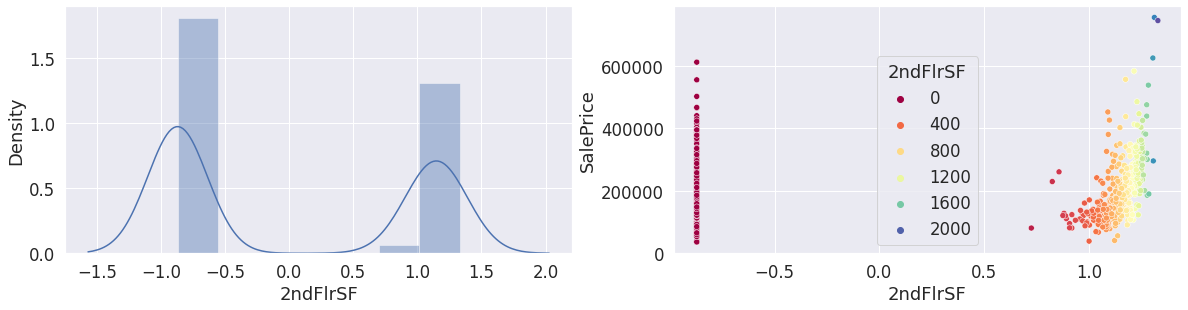

In [ ]:
# 2ndFlrSF: Second Floor square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['2ndFlrSF']])
normalized_test = pt.transform(df_test[['2ndFlrSF']])
df_normalized = pd.DataFrame(normalized, columns=['2ndFlrSF'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['2ndFlrSF'])

print('Correlación: ', df_normalized['2ndFlrSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['2ndFlrSF'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['2ndFlrSF'], y = df_num.SalePrice, hue=df_num['2ndFlrSF'], palette= 'Spectral')

df_train['2ndFlrSF'] = df_normalized['2ndFlrSF']
df_test['2ndFlrSF'] = df_normalized_test['2ndFlrSF']

Correlación:  0.3158562271160555


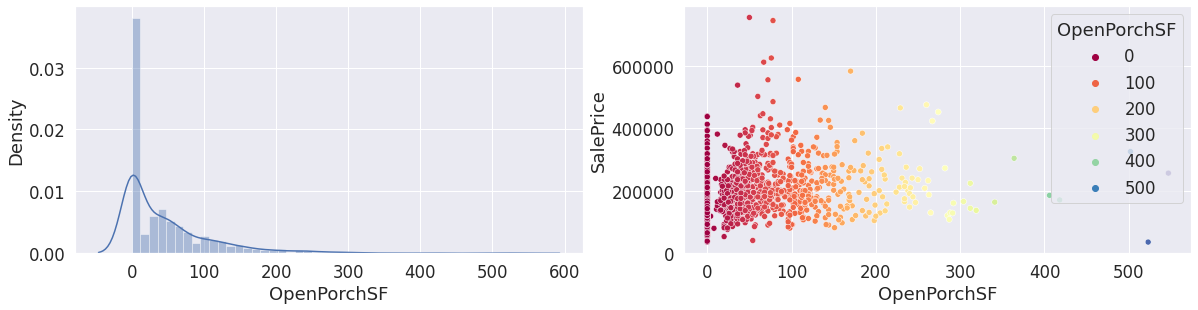

In [ ]:
# OpenPorchSF: Open porch area in square feet
print('Correlación: ', df_num['OpenPorchSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['OpenPorchSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['OpenPorchSF'], y = df_num.SalePrice, hue=df_num['OpenPorchSF'], palette= 'Spectral')

Correlación:  0.4299207599858631


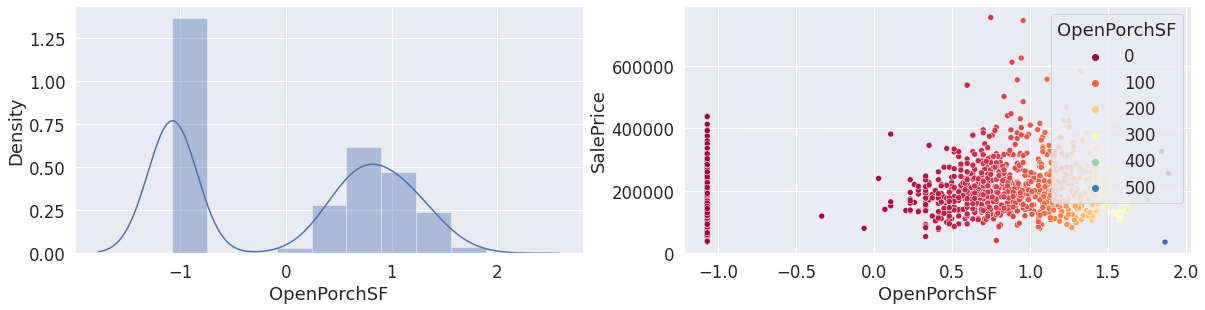

In [ ]:
# OpenPorchSF: Open porch area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['OpenPorchSF']])
normalized_test = pt.transform(df_test[['OpenPorchSF']])
df_normalized = pd.DataFrame(normalized, columns=['OpenPorchSF'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['OpenPorchSF'])

print('Correlación: ', df_normalized['OpenPorchSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['OpenPorchSF'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['OpenPorchSF'], y = df_num.SalePrice, hue=df_num['OpenPorchSF'], palette= 'Spectral')

df_train['OpenPorchSF'] = df_normalized['OpenPorchSF']
df_test['OpenPorchSF'] = df_normalized_test['OpenPorchSF']

Correlación:  0.2841076755947831


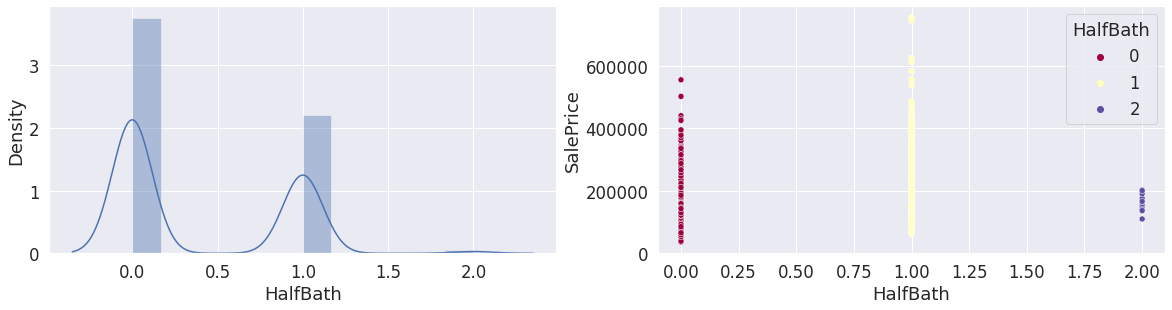

In [ ]:
# HalfBath: Half baths above grade
print('Correlación: ', df_num['HalfBath']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['HalfBath'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['HalfBath'], y = df_num.SalePrice, hue=df_num['HalfBath'], palette= 'Spectral')

Correlación:  0.2638433538714056


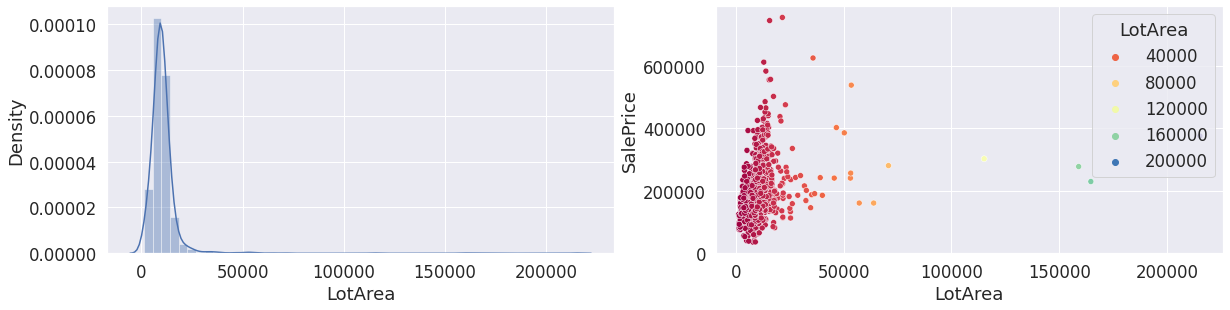

In [ ]:
# LotArea: Lot size in square feet
print('Correlación: ', df_num['LotArea']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['LotArea'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['LotArea'], y = df_num.SalePrice, hue=df_num['LotArea'], palette= 'Spectral')

In [ ]:
df_train['LotArea'] = np.log1p(df_train['LotArea'])
df_test['LotArea'] = np.log1p(df_test['LotArea'])

Correlación:  0.22712223313149382


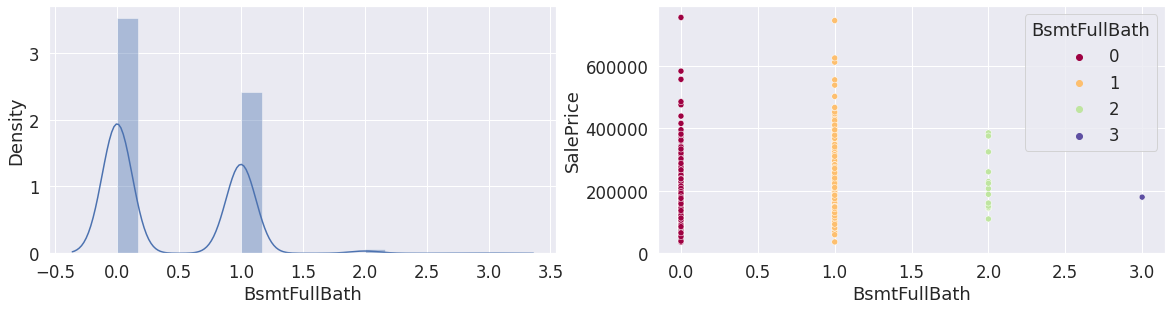

In [ ]:
# BsmtFullBath: Basement full bathrooms
print('Correlación: ', df_num['BsmtFullBath']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BsmtFullBath'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BsmtFullBath'], y = df_num.SalePrice, hue=df_num['BsmtFullBath'], palette= 'Spectral')

Correlación:  0.21447910554696892


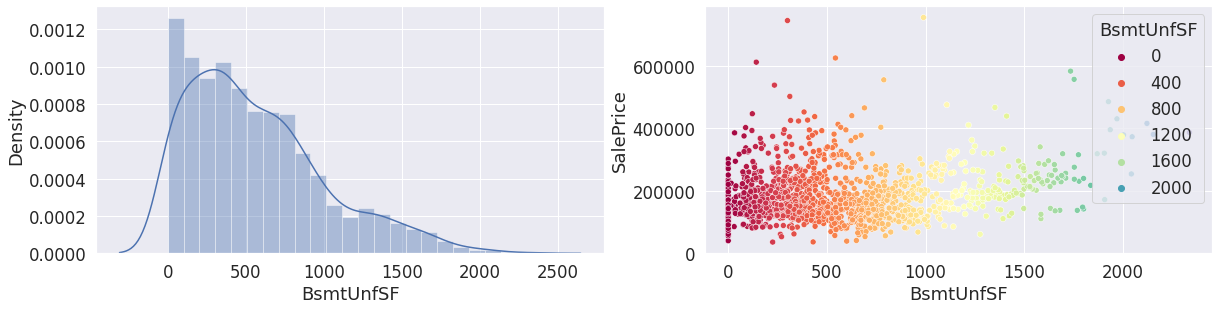

In [ ]:
# BsmtUnfSF: Unfinished square feet of basement area
print('Correlación: ', df_num['BsmtUnfSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BsmtUnfSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BsmtUnfSF'], y = df_num.SalePrice, hue=df_num['BsmtUnfSF'], palette= 'Spectral')

In [ ]:
df_train['BsmtUnfSF'] = np.log1p(df_train['BsmtUnfSF'])
df_test['BsmtUnfSF'] = np.log1p(df_test['BsmtUnfSF'])
print('Correlación: ', df_train['BsmtUnfSF']. corr (df_train['SalePrice']))

Correlación:  0.1865722469231705


Correlación:  0.16821315430073988


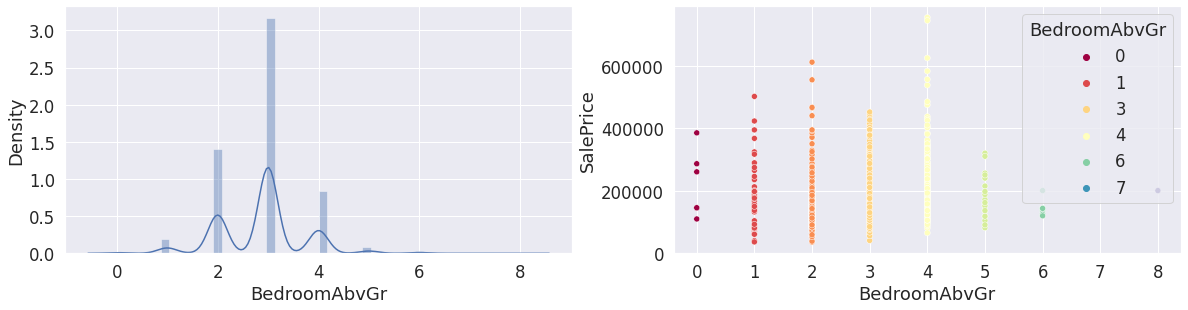

In [ ]:
# BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
print('Correlación: ', df_num['BedroomAbvGr']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BedroomAbvGr'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BedroomAbvGr'], y = df_num.SalePrice, hue=df_num['BedroomAbvGr'], palette= 'Spectral')

Correlación:  0.11144657114291105


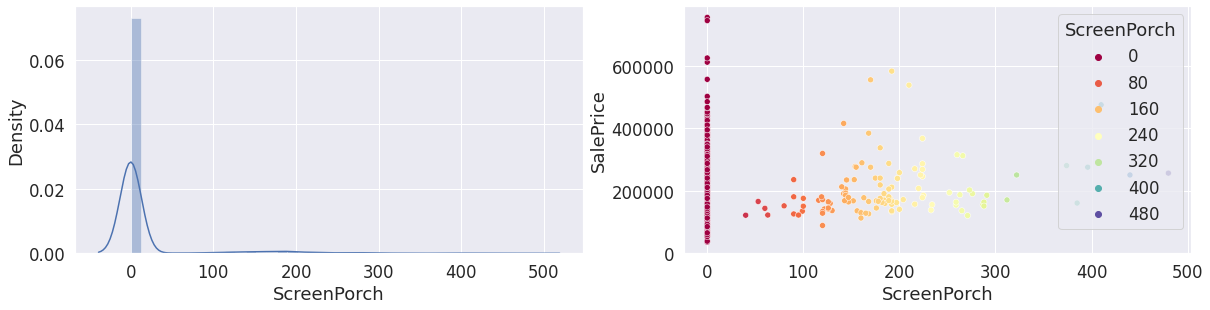

In [ ]:
# ScreenPorch: Screen porch area in square feet
print('Correlación: ', df_num['ScreenPorch']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['ScreenPorch'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['ScreenPorch'], y = df_num.SalePrice, hue=df_num['ScreenPorch'], palette= 'Spectral')

Correlación:  0.08714383828090158


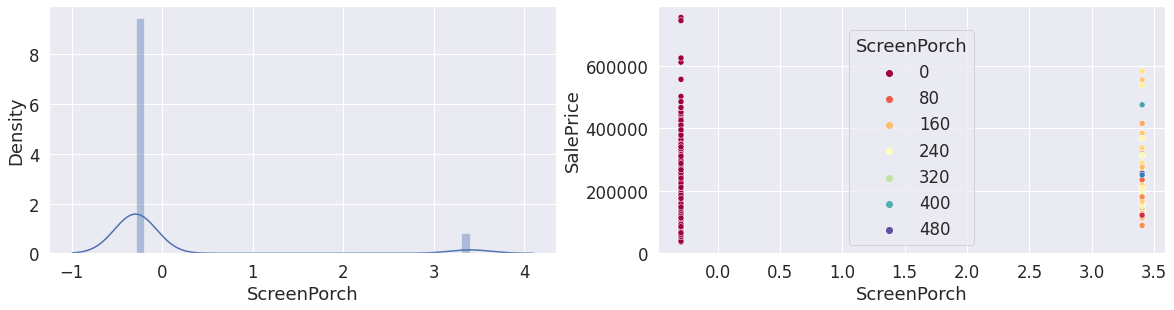

In [ ]:
# ScreenPorch: Screen porch area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['ScreenPorch']])
normalized_test = pt.transform(df_test[['ScreenPorch']])
df_normalized = pd.DataFrame(normalized, columns=['ScreenPorch'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['ScreenPorch'])

print('Correlación: ', df_normalized['ScreenPorch']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['ScreenPorch'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['ScreenPorch'], y = df_num.SalePrice, hue=df_num['ScreenPorch'], palette= 'Spectral')

df_train['ScreenPorch'] = df_normalized['ScreenPorch']
df_test['ScreenPorch'] = df_normalized_test['ScreenPorch']

Correlación:  0.09240354949187321


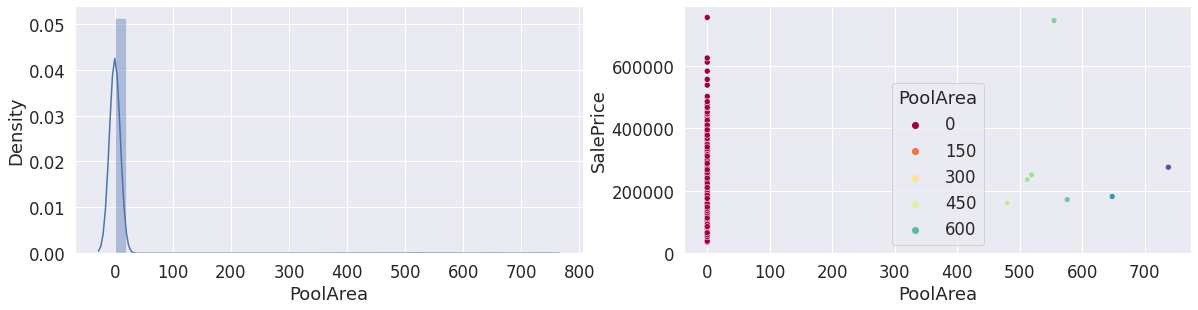

In [ ]:
# PoolArea: Pool area in square feet
print('Correlación: ', df_num['PoolArea']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['PoolArea'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['PoolArea'], y = df_num.SalePrice, hue=df_num['PoolArea'], palette= 'Spectral')

Correlación:  0.09370812512551792


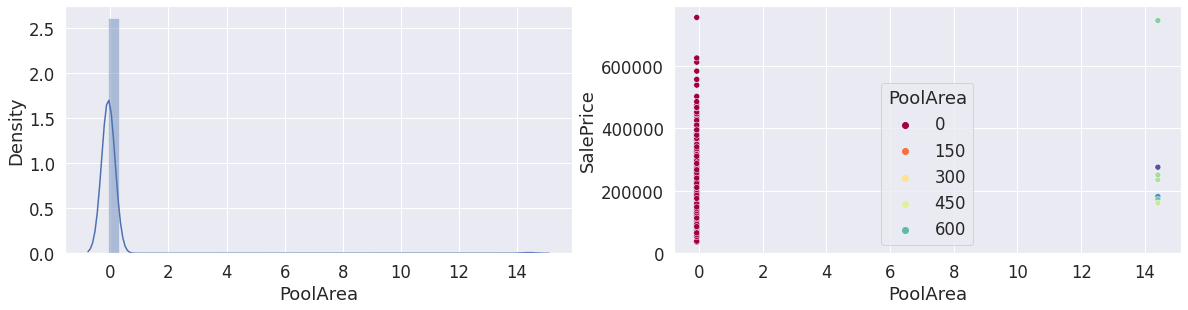

In [ ]:
# PoolArea: Pool area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['PoolArea']])
normalized_test = pt.transform(df_test[['PoolArea']])
df_normalized = pd.DataFrame(normalized, columns=['PoolArea'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['PoolArea'])

print('Correlación: ', df_normalized['PoolArea']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['PoolArea'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['PoolArea'], y = df_num.SalePrice, hue=df_num['PoolArea'], palette= 'Spectral')

df_train['PoolArea'] = df_normalized['PoolArea']
df_test['PoolArea'] = df_normalized_test['PoolArea']

Correlación:  0.04458366533574846


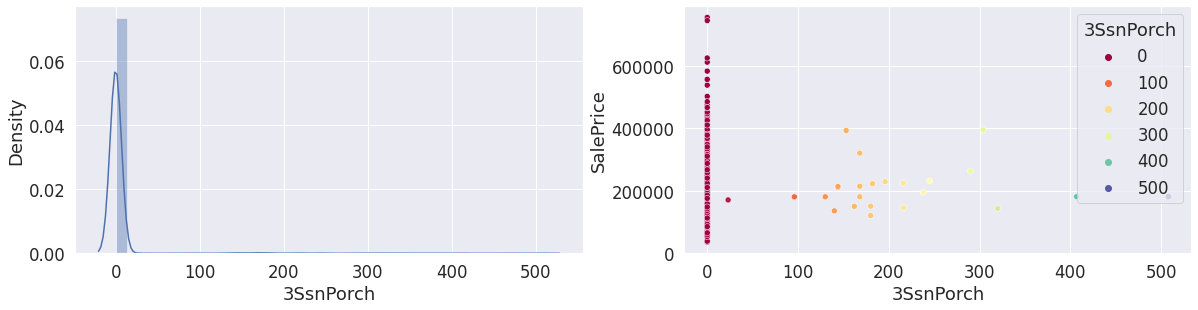

In [ ]:
# 3SsnPorch: Three season porch area in square feet
print('Correlación: ', df_num['3SsnPorch']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['3SsnPorch'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['3SsnPorch'], y = df_num.SalePrice, hue=df_num['3SsnPorch'], palette= 'Spectral')

Correlación:  0.0460148248000327


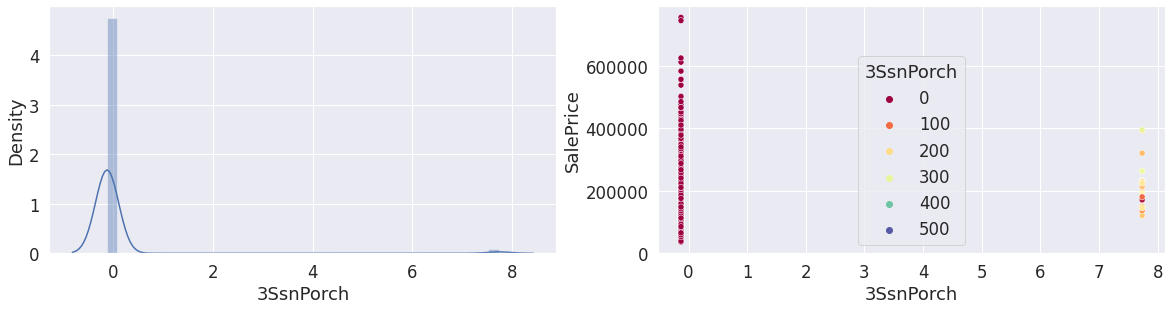

In [ ]:
# 3SsnPorch: Three season porch area in square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['3SsnPorch']])
normalized_test = pt.transform(df_test[['3SsnPorch']])
df_normalized = pd.DataFrame(normalized, columns=['3SsnPorch'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['3SsnPorch'])

print('Correlación: ', df_normalized['3SsnPorch']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['3SsnPorch'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['3SsnPorch'], y = df_num.SalePrice, hue=df_num['3SsnPorch'], palette= 'Spectral')

df_train['3SsnPorch'] = df_normalized['3SsnPorch']
df_test['3SsnPorch'] = df_normalized_test['3SsnPorch']

Correlación:  -0.011378121450215125


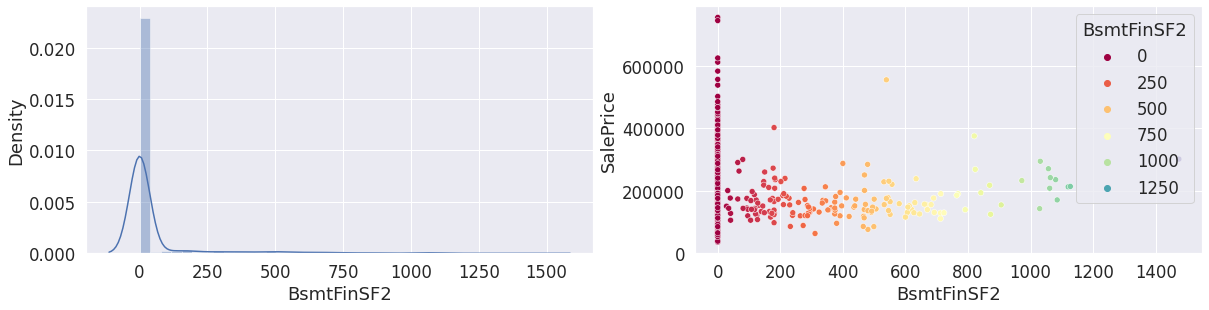

In [ ]:
# BsmtFinSF2: Type 2 finished square feet
print('Correlación: ', df_num['BsmtFinSF2']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BsmtFinSF2'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BsmtFinSF2'], y = df_num.SalePrice, hue=df_num['BsmtFinSF2'], palette= 'Spectral')

Correlación:  -0.05295993074763012


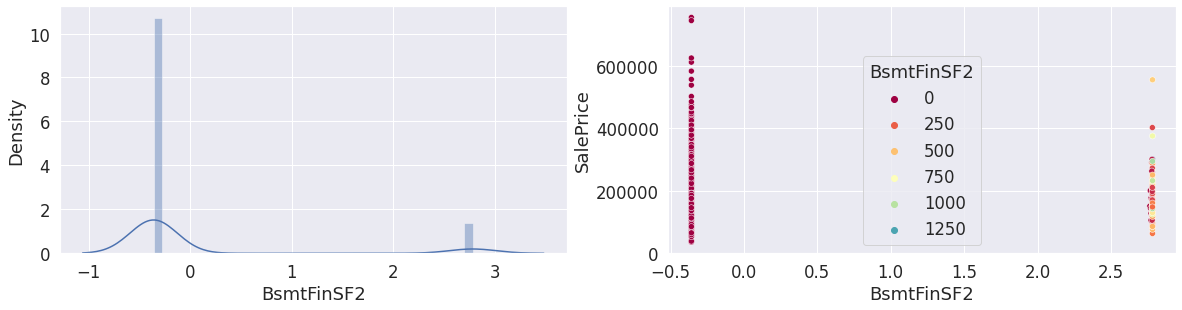

In [ ]:
# BsmtFinSF2: Type 2 finished square feet
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['BsmtFinSF2']])
normalized_test = pt.transform(df_test[['BsmtFinSF2']])
df_normalized = pd.DataFrame(normalized, columns=['BsmtFinSF2'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['BsmtFinSF2'])

print('Correlación: ', df_normalized['BsmtFinSF2']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['BsmtFinSF2'])
fig2 = fig.add_subplot(222);
sns.scatterplot(x = df_normalized['BsmtFinSF2'], y = df_num.SalePrice, hue=df_num['BsmtFinSF2'], palette= 'Spectral')

df_train['BsmtFinSF2'] = df_normalized['BsmtFinSF2']
df_test['BsmtFinSF2'] = df_normalized_test['BsmtFinSF2']

Correlación:  -0.016844154297359016


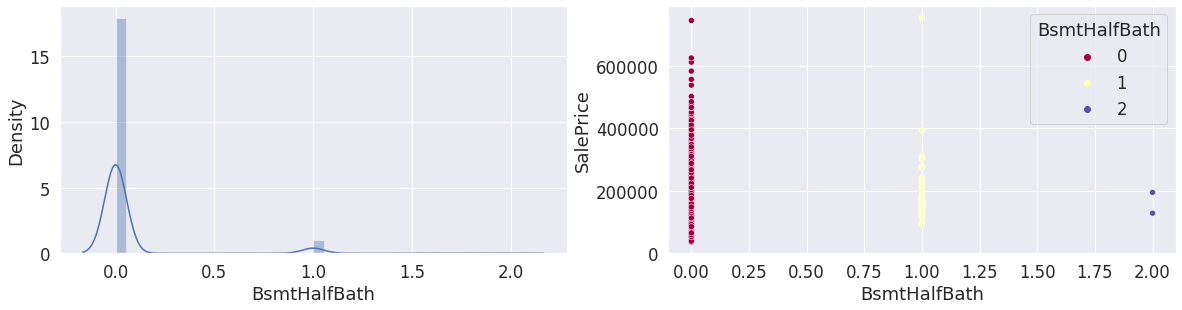

In [ ]:
# BsmtHalfBath: Basement half bathrooms
print('Correlación: ', df_num['BsmtHalfBath']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['BsmtHalfBath'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['BsmtHalfBath'], y = df_num.SalePrice, hue=df_num['BsmtHalfBath'], palette= 'Spectral')

Correlación:  -0.02118957964030325


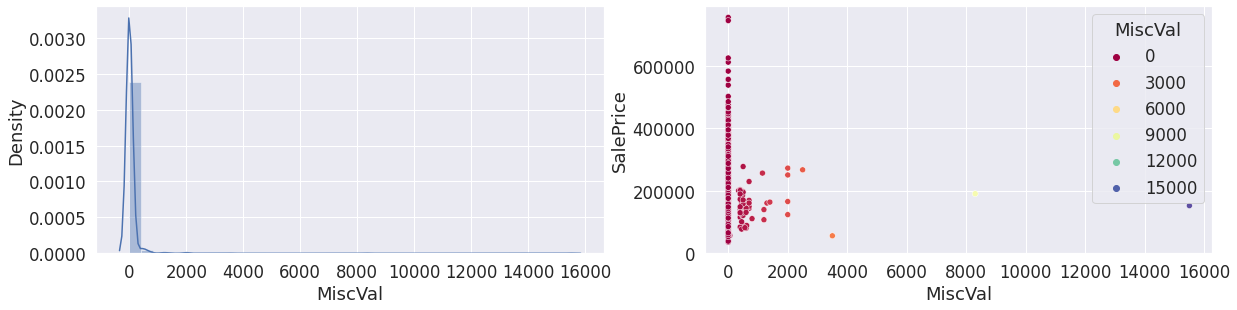

In [ ]:
# MiscVal: $Value of miscellaneous feature
print('Correlación: ', df_num['MiscVal']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['MiscVal'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['MiscVal'], y = df_num.SalePrice, hue=df_num['MiscVal'], palette= 'Spectral')

Correlación:  -0.06837404572385734


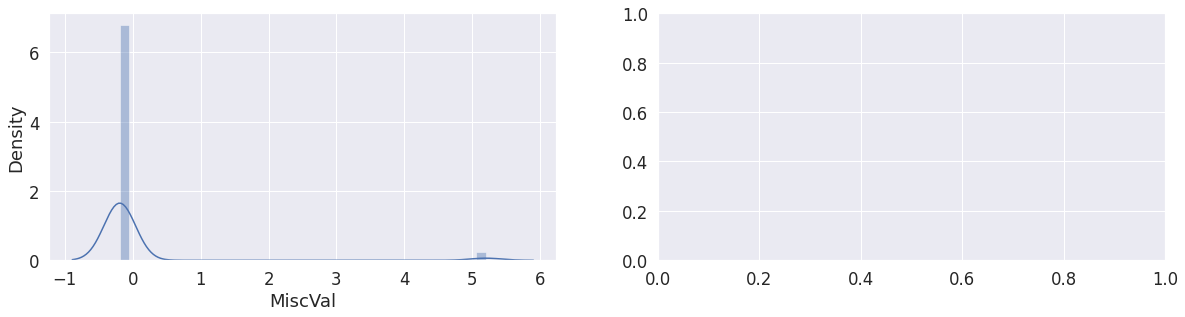

In [ ]:
# MiscVal: $Value of miscellaneous feature
df_normalized = pd.DataFrame()
df_normalized_test = pd.DataFrame()
pt = PowerTransformer(method='yeo-johnson')
# Normalizamos usando Yeo-Johnson
normalized = pt.fit_transform(df_train[['MiscVal']])
normalized_test = pt.transform(df_test[['MiscVal']])
df_normalized = pd.DataFrame(normalized, columns=['MiscVal'])
df_normalized_test = pd.DataFrame(normalized_test, columns=['MiscVal'])

print('Correlación: ', df_normalized['MiscVal']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_normalized['MiscVal'])
fig2 = fig.add_subplot(222);

df_train['MiscVal'] = df_normalized['MiscVal']
df_test['MiscVal'] = df_normalized_test['MiscVal']

Correlación:  -0.02560613000067959


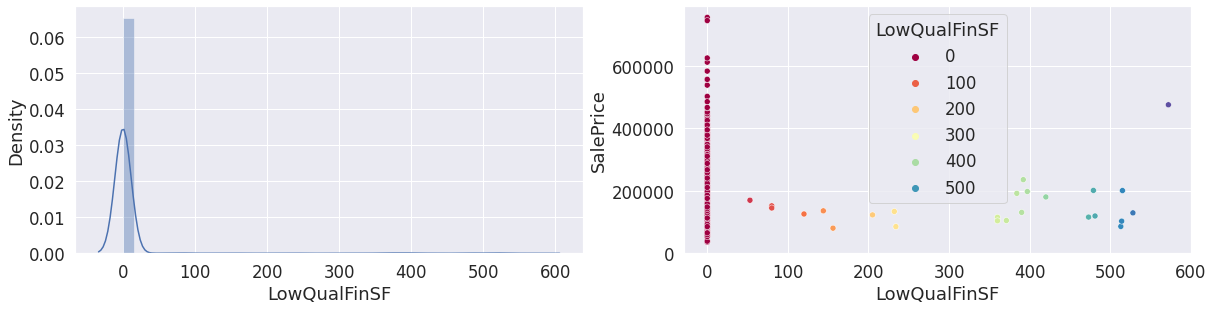

In [ ]:
# LowQualFinSF: Low quality finished square feet (all floors)
print('Correlación: ', df_num['LowQualFinSF']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['LowQualFinSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['LowQualFinSF'], y = df_num.SalePrice, hue=df_num['LowQualFinSF'], palette= 'Spectral')

In [ ]:
df_train['LowQualFinSF'] = np.log1p(df_train['LowQualFinSF'])
df_test['LowQualFinSF'] = np.log1p(df_test['LowQualFinSF'])

Correlación:  -0.07785589404867803


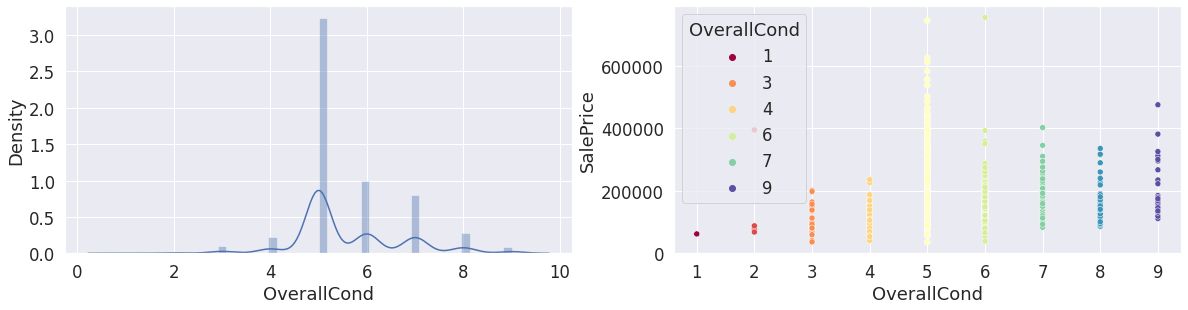

In [ ]:
# OverallCond: Rates the overall condition of the house
print('Correlación: ', df_num['OverallCond']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['OverallCond'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['OverallCond'], y = df_num.SalePrice, hue=df_num['OverallCond'], palette= 'Spectral')

Correlación:  -0.12857795792595653


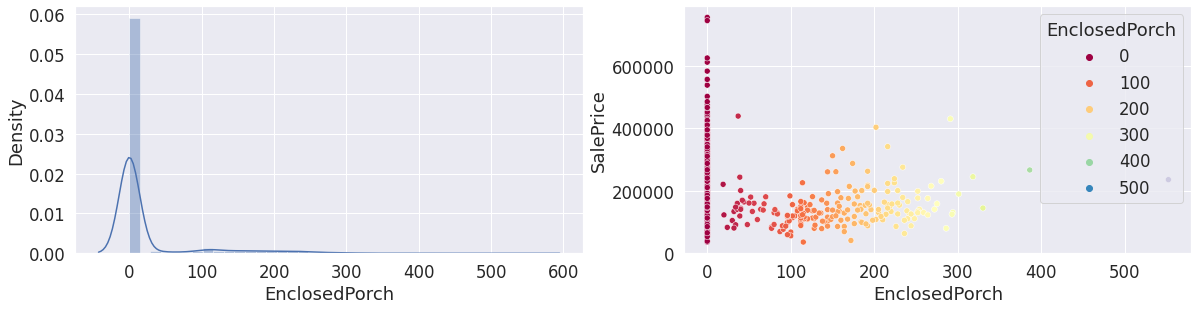

In [ ]:
# EnclosedPorch: Enclosed porch area in square feet
print('Correlación: ', df_num['EnclosedPorch']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['EnclosedPorch'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['EnclosedPorch'], y = df_num.SalePrice, hue=df_num['EnclosedPorch'], palette= 'Spectral')

In [ ]:
df_train['EnclosedPorch'] = np.log1p(df_train['EnclosedPorch'])
df_test['EnclosedPorch'] = np.log1p(df_test['EnclosedPorch'])

Correlación:  -0.13590737084214122


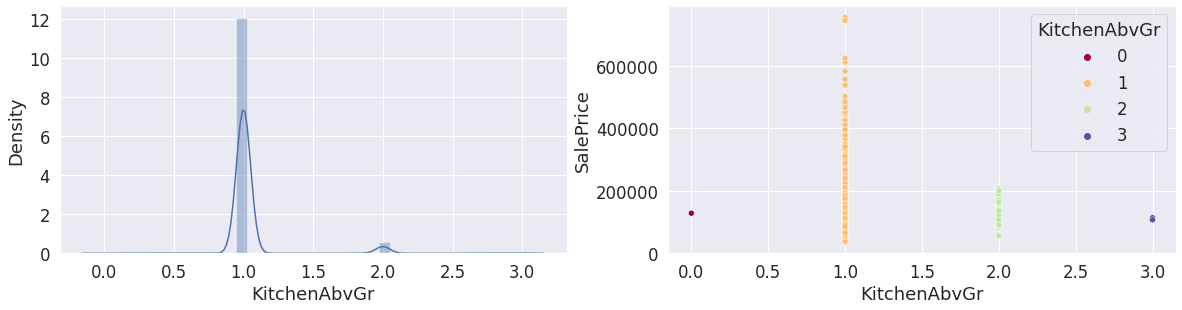

In [ ]:
# KitchenAbvGr: Kitchens above grade
print('Correlación: ', df_num['KitchenAbvGr']. corr (df_num['SalePrice']))
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_num['KitchenAbvGr'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_num['KitchenAbvGr'], y = df_num.SalePrice, hue=df_num['KitchenAbvGr'], palette= 'Spectral')

### CREACIÓN DE VARIABLES NUMÉRICAS

Correlación GrLivArea:  0.6953642208523488
Correlación TotRmsAbvGrd:  0.5337231555820282
Correlación FullBath:  0.5606637627484449
Correlación HalfBath:  0.2841076755947831
Correlación KitchenAbvGr:  -0.13590737084214122
Correlación SqFtPerRoom:  0.621827961476399


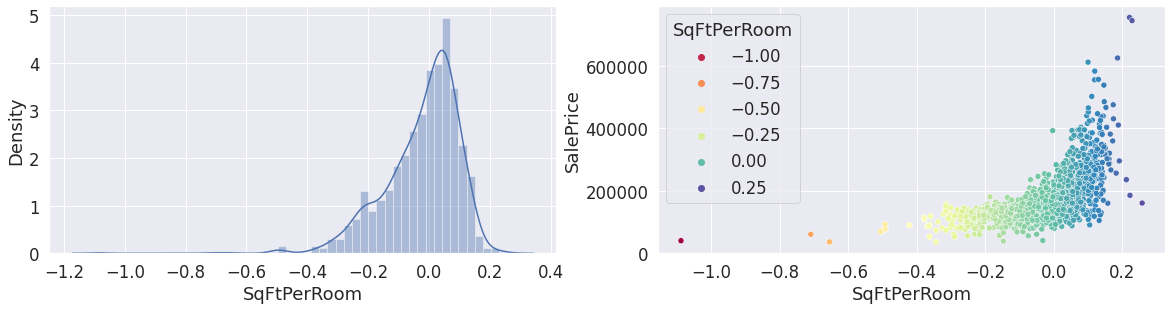

In [ ]:
# Se crea una nueva variable
df_train["SqFtPerRoom"] = df_train["GrLivArea"] / (df_train["TotRmsAbvGrd"] + df_train["FullBath"] +
                                                       df_train["HalfBath"] + df_train["KitchenAbvGr"])
df_test["SqFtPerRoom"] = df_test["GrLivArea"] / (df_test["TotRmsAbvGrd"] + df_test["FullBath"] +
                                                       df_test["HalfBath"] + df_test["KitchenAbvGr"])
print('Correlación GrLivArea: ', df_train['GrLivArea']. corr (df_train['SalePrice']))
print('Correlación TotRmsAbvGrd: ', df_train['TotRmsAbvGrd']. corr (df_train['SalePrice']))
print('Correlación FullBath: ', df_train['FullBath']. corr (df_train['SalePrice']))
print('Correlación HalfBath: ', df_train['HalfBath']. corr (df_train['SalePrice']))
print('Correlación KitchenAbvGr: ', df_train['KitchenAbvGr']. corr (df_train['SalePrice']))
print('Correlación SqFtPerRoom: ', df_train['SqFtPerRoom']. corr (df_train['SalePrice']))

fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_train['SqFtPerRoom'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_train['SqFtPerRoom'], y = df_train.SalePrice, hue=df_train['SqFtPerRoom'], palette= 'Spectral')

Correlación Total Baños:  0.6317310679319873


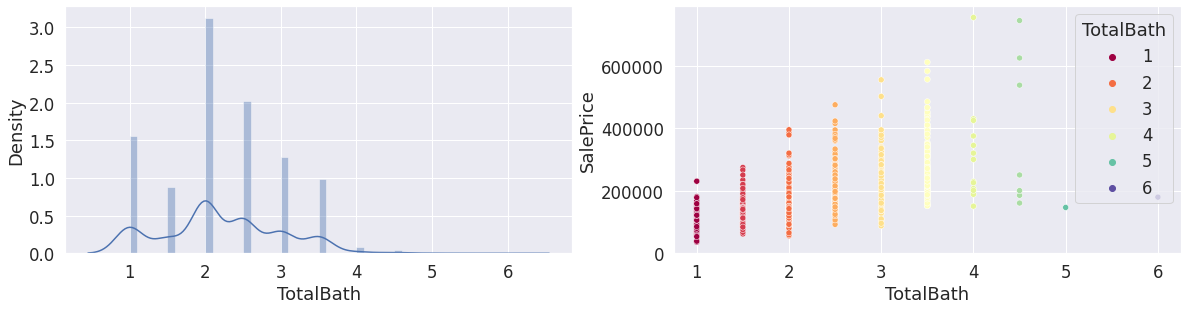

In [ ]:
# Se unen las variables de los baños en una variable que tiene mejor correlación que las variables por separado
df_train['TotalBath'] = df_train['FullBath'] + df_train['BsmtFullBath'] + 0.5 * df_train['BsmtHalfBath'] + 0.5 * df_train['HalfBath']
df_test['TotalBath'] = df_test['FullBath'] + df_test['BsmtFullBath'] + 0.5 * df_test['BsmtHalfBath'] + 0.5 * df_test['HalfBath']
print('Correlación Total Baños: ', df_train['TotalBath']. corr (df_train['SalePrice']))

fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_train['TotalBath'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_train['TotalBath'], y = df_train.SalePrice, hue=df_train['TotalBath'], palette= 'Spectral')

df_train = df_train.drop(['FullBath', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath'], axis=1)
df_test = df_test.drop(['FullBath', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath'], axis=1)

Correlación 1stFlrSF:  0.5882901851970442
Correlación 2ndFlrSF:  0.1569410363781141
Correlación HighQualSF:  0.6573784686802837


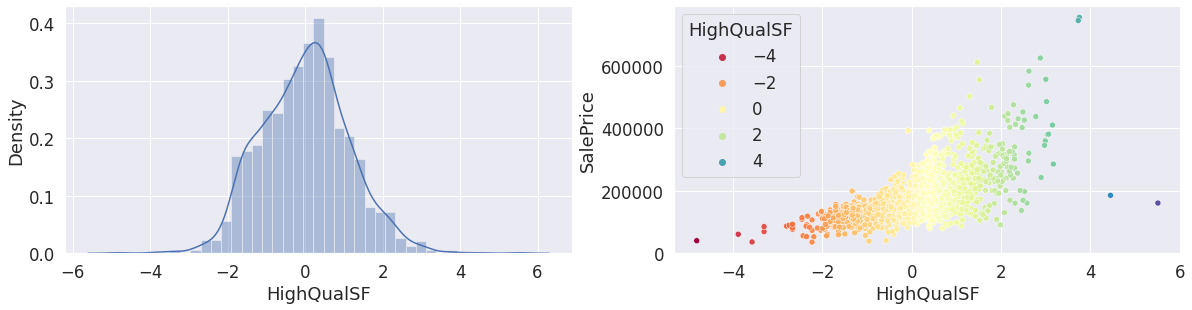

In [ ]:
# Se unen las variables de los pisos
df_train['HighQualSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] 
df_test['HighQualSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF'] 
print('Correlación 1stFlrSF: ', df_train['1stFlrSF']. corr (df_train['SalePrice']))
print('Correlación 2ndFlrSF: ', df_train['2ndFlrSF']. corr (df_train['SalePrice']))
print('Correlación HighQualSF: ', df_train['HighQualSF']. corr (df_train['SalePrice']))

fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1.5)
fig1 = fig.add_subplot(221);
sns.distplot(df_train['HighQualSF'])
fig1 = fig.add_subplot(222);
sns.scatterplot(x = df_train['HighQualSF'], y = df_train.SalePrice, hue=df_train['HighQualSF'], palette= 'Spectral')

df_train = df_train.drop('2ndFlrSF', axis=1)
df_test = df_test.drop('2ndFlrSF', axis=1)

### Columnas temporales (YearBuilt, GarageYrBlt, YearRemodAdd, YrSold)

In [ ]:
# Se transforman las variables temporales
df_train['YearBuilt_age'] = df_train['YearBuilt'].apply(lambda x: 0 if x==0 else (2022 - x))
df_test['YearBuilt_age'] = df_test['YearBuilt'].apply(lambda x: 0 if x==0 else (2022 - x))
df_train['YearRemodAdd_age'] = df_train['YearRemodAdd'].apply(lambda x: 0 if x==0 else (2022 - x))
df_test['YearRemodAdd_age'] = df_test['YearRemodAdd'].apply(lambda x: 0 if x==0 else (2022 - x))
df_train['YrSold_age'] = df_train['YrSold'].apply(lambda x: 0 if x==0 else (2022 - x))
df_test['YrSold_age'] = df_test['YrSold'].apply(lambda x: 0 if x==0 else (2022 - x))
df_train['GarageYrBlt_age'] = df_train['GarageYrBlt'].apply(lambda x: 0 if x==0 else (2022 - x))
df_test['GarageYrBlt_age'] = df_test['GarageYrBlt'].apply(lambda x: 0 if x==0 else (2022 - x))

df_train['renovated'] = df_train['YearRemodAdd'] + df_train['YearBuilt']
df_test['renovated'] = df_test['YearRemodAdd'] + df_test['YearBuilt']

df_train = df_train.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis=1)
df_test = df_test.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis=1)
print(df_train.shape)
print(df_test.shape)

(1460, 146)
(1459, 145)


### VARIABLE OBJETIVO

In [ ]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

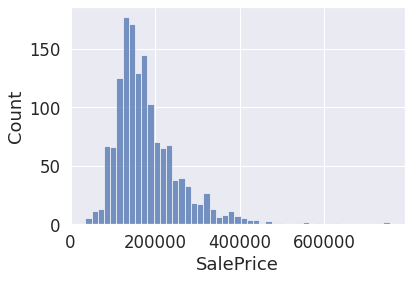

In [ ]:
sns.histplot(df_train['SalePrice']);

In [ ]:
# Transformación logaritmica de la variable objetivo para hacerla más normalmente distribuida
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [ ]:
df_train['SalePrice'].describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

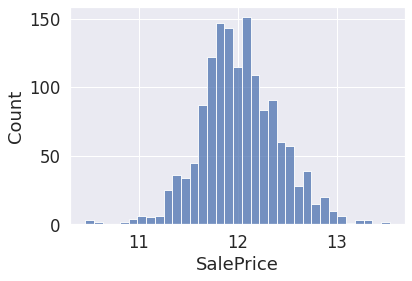

In [ ]:
sns.histplot(df_train['SalePrice']);

### Se separan los datos (Train y Test)

In [ ]:
#y_test = 0
#X_test = df_test.copy()
#y_train = df_train['SalePrice']
#X = df_train
#X_train = df_train.drop('SalePrice', axis=1)

In [ ]:
# Se separan los datos en datos de entrenamiento y datos de test
y = df_train['SalePrice']
X = df_train.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 145), (292, 145), (1168,), (292,))

### VALIDACIÓN CRUZADA

In [ ]:
# Se definen las variables necesarias para la validación cruzada
nr_cv = 5
score_calc = 'neg_mean_squared_error'

### REGRESIÓN LINEAL

In [ ]:
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X_train, y_train)

best_score_linear = np.sqrt(-grid_linear.best_score_)
print('best_score: ', best_score_linear)    
print('best_params: ', grid_linear.best_params_)
print('best_estimator: ', grid_linear.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best_score:  378852.7121679677
best_params:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
best_estimator:  LinearRegression(normalize=False)


In [ ]:
y_pred_linear = grid_linear.predict(X_test)  

print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_linear))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_linear)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_linear) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_linear) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_score_linear = metrics.r2_score(y_test, y_pred_linear)
print('r2_score: ', r2_score_linear)

mean_absolute_error:  0.09337549627641545
mean_squared_error:  0.16093766466241333
El ratio entre el mae y la mediana del precio es: 0.007776545826093849.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.04640683236281622
r2_score:  0.828921647209055


### RIDGE

In [ ]:
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1],
              'normalize':[True,False],
              'tol':[1e-06,5e-06,1e-05,5e-05]}

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()

grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X_train, y_train)

best_score_ridge = np.sqrt(-grid_ridge.best_score_)
print('best_score: ', best_score_ridge)    
print('best_params: ', grid_ridge.best_params_)
print('best_estimator: ', grid_ridge.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_score:  0.1236085607729754
best_params:  {'alpha': 0.1, 'normalize': True, 'tol': 1e-06}
best_estimator:  Ridge(alpha=0.1, normalize=True, tol=1e-06)


In [ ]:
y_pred_ridge = grid_ridge.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_ridge))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_ridge) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_ridge) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_score_ridge = metrics.r2_score(y_test, y_pred_ridge)
print('r2_score: ', r2_score_ridge)

mean_absolute_error:  0.09249728909431063
mean_squared_error:  0.15678705378070296
El ratio entre el mae y la mediana del precio es: 0.007703406526504735.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.04520999193522053
r2_score:  0.8376321393603426


### LASSO

In [ ]:
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1],
              'normalize':[True,False],
              'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X_train, y_train)

best_score_lasso = np.sqrt(-grid_lasso.best_score_)
print('best_score: ', best_score_lasso)    
print('best_params: ', grid_lasso.best_params_)
print('best_estimator: ', grid_lasso.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best_score:  0.12406972021699944
best_params:  {'alpha': 0.001, 'normalize': False, 'tol': 1e-06}
best_estimator:  Lasso(alpha=0.001, normalize=False, tol=1e-06)


In [ ]:
y_pred_lasso = grid_lasso.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_lasso))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_lasso) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_lasso) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print('r2_score: ', r2_score_lasso)

mean_absolute_error:  0.09042423058790122
mean_squared_error:  0.15663153093556617
El ratio entre el mae y la mediana del precio es: 0.007530757007967844.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.045165146481435735
r2_score:  0.8379540969057763


### ELASTIC NET

In [ ]:
parameters = {'alpha' :[0.1,1.0,10],
              'max_iter' :[1000000],
              'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True],
              'normalize':[True,False],
              'tol':[1e-02,1e-03,1e-04]}

In [ ]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()

grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_train, y_train)

best_score_enet = np.sqrt(-grid_enet.best_score_)
print('best_score: ', best_score_enet)    
print('best_params: ', grid_enet.best_params_)
print('best_estimator: ', grid_enet.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best_score:  0.133195199885704
best_params:  {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.0001}
best_estimator:  ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000, normalize=False)


In [ ]:
y_pred_enet = grid_enet.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_enet))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_enet)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_enet) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_enet) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_enet = np.sqrt(mean_squared_error(y_test, y_pred_enet))
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print('r2_score: ', r2_score_enet)

mean_absolute_error:  0.09483545750089542
mean_squared_error:  0.15853452635860732
El ratio entre el mae y la mediana del precio es: 0.007898135063305283.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.0457138806125636
r2_score:  0.8339926225179572


### SGD REGRESSOR

In [ ]:
parameters = {'max_iter' :[10000, 15000],
              'alpha':[1e-05, 1e-03],
              'epsilon':[1e-02, 1e-01],
              'fit_intercept' : [True] }

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_sgd.fit(X_train, y_train)

best_score_sgd = np.sqrt(-grid_sgd.best_score_)
print('best_score: ', best_score_sgd)    
print('best_params: ', grid_sgd.best_params_)
print('best_estimator: ', grid_sgd.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best_score:  3958066874695674.0
best_params:  {'alpha': 0.001, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
best_estimator:  SGDRegressor(alpha=0.001, epsilon=0.01, max_iter=10000)


In [ ]:
y_pred_sgd = grid_sgd.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_sgd))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_sgd)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_sgd) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_sgd) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))
r2_score_sgd = metrics.r2_score(y_test, y_pred_sgd)
print('r2_score: ', r2_score_sgd)

mean_absolute_error:  917878874801779.5
mean_squared_error:  920406468636394.9
El ratio entre el mae y la mediana del precio es: 76443257785419.4.
El ratio entre la raíz cuadrada del mse y la media del precio es: 265401817438179.88
r2_score:  -5.595501215156368e+30


### RANDOM FOREST REGRESSOR

In [ ]:
param_grid = {'min_samples_split' : [3,4,6,10],
              'n_estimators' : [70,100],
              'random_state': [5] }

In [ ]:
from sklearn.ensemble import RandomForestRegressor

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X_train, y_train)

best_score_rf = np.sqrt(-grid_rf.best_score_)
print('best_score: ', best_score_rf)    
print('best_params: ', grid_rf.best_params_)
print('best_estimator: ', grid_rf.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
best_score:  0.14201316328510014
best_params:  {'min_samples_split': 3, 'n_estimators': 100, 'random_state': 5}
best_estimator:  RandomForestRegressor(min_samples_split=3, random_state=5)


In [ ]:
y_pred_rf = grid_rf.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_rf))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_rf) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_rf) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_score_rf = metrics.r2_score(y_test, y_pred_rf)
print('r2_score: ', r2_score_rf)

mean_absolute_error:  0.09336248436238472
mean_squared_error:  0.14050942048278486
El ratio entre el mae y la mediana del precio es: 0.007775462161216227.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.0405162901761922
r2_score:  0.869596107505981


### KNN REGRESSOR

In [ ]:
param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_train, y_train)

best_score_knn = np.sqrt(-grid_knn.best_score_)
print('best_score: ', best_score_knn)    
print('best_params: ', grid_knn.best_params_)
print('best_estimator: ', grid_knn.best_estimator_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
best_score:  0.2226602753840761
best_params:  {'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'distance'}
best_estimator:  KNeighborsRegressor(algorithm='brute', n_neighbors=6, weights='distance')


In [ ]:
y_pred_knn = grid_knn.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_knn))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_knn)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_knn) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_knn) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_score_knn = metrics.r2_score(y_test, y_pred_knn)
print('r2_score: ', r2_score_knn)

mean_absolute_error:  0.15329866871656825
mean_squared_error:  0.20769928658796172
El ratio entre el mae y la mediana del precio es: 0.012767098113455262.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.05989067875927214
r2_score:  0.7150624540824648


### HUBER REGRESSOR

In [ ]:
param_grid = { 'max_iter' : [2000], 
               'alpha' : [0.5],
               'epsilon' : [1.05], 
               'tol' : [1e-01] }

In [ ]:
from sklearn.linear_model import HuberRegressor

grid_hub = GridSearchCV(HuberRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_hub.fit(X_train, y_train)

best_score_hub = np.sqrt(-grid_hub.best_score_)
print('best_score: ', best_score_hub)    
print('best_params: ', grid_hub.best_params_)
print('best_estimator: ', grid_hub.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best_score:  0.12501011978115267
best_params:  {'alpha': 0.5, 'epsilon': 1.05, 'max_iter': 2000, 'tol': 0.1}
best_estimator:  HuberRegressor(alpha=0.5, epsilon=1.05, max_iter=2000, tol=0.1)


In [ ]:
y_pred_hub = grid_hub.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_hub))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_hub)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_hub) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_hub) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_hub = np.sqrt(mean_squared_error(y_test, y_pred_hub))
r2_score_hub = metrics.r2_score(y_test, y_pred_hub)
print('r2_score: ', r2_score_hub)

mean_absolute_error:  0.0875538254322996
mean_squared_error:  0.1604518156245826
El ratio entre el mae y la mediana del precio es: 0.007291702458089858.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.0462667364138689
r2_score:  0.8299530128858261


### Passive Aggressive Regressor

In [ ]:
param_grid = { 'C' : [0.001, 0.005, 0.003],
               'max_iter' : [1000, 2000], 
               'epsilon' : [0.00001, 0.00005],
               'tol' : [1e-03] }

In [ ]:
from sklearn.linear_model import PassiveAggressiveRegressor

grid_par = GridSearchCV(PassiveAggressiveRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_par.fit(X_train, y_train)

best_score_par = np.sqrt(-grid_par.best_score_)
print('best_score: ', best_score_par)    
print('best_params: ', grid_par.best_params_)
print('best_estimator: ', grid_par.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best_score:  0.3217395100759386
best_params:  {'C': 0.003, 'epsilon': 1e-05, 'max_iter': 1000, 'tol': 0.001}
best_estimator:  PassiveAggressiveRegressor(C=0.003, epsilon=1e-05)


In [ ]:
y_pred_par = grid_par.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_par))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_par)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_par) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_par) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_par = np.sqrt(mean_squared_error(y_test, y_pred_par))
r2_score_par = metrics.r2_score(y_test, y_pred_par)
print('r2_score: ', r2_score_par)

mean_absolute_error:  0.2809884157972246
mean_squared_error:  0.3406692616098335
El ratio entre el mae y la mediana del precio es: 0.023401420920753296.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.09823294843909945
r2_score:  0.23344103293251983


### XGBoost

In [ ]:
# Se seleccionan los hiperparámetros
param_grid = {"n_estimators": [300],
               "max_depth": [30],
               "learning_rate": [0.03, 0.01],
               "objective": ["reg:squarederror"],
               "tree_method": ["hist"],
               "subsample": [0.6] }

In [ ]:
from xgboost import XGBRegressor

grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_xgb.fit(X_train, y_train)

best_score_xgb = np.sqrt(-grid_xgb.best_score_)
print('best_score: ', best_score_xgb)    
print('best_params: ', grid_xgb.best_params_)
print('best_estimator: ', grid_xgb.best_estimator_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
best_score:  0.1274902931563532
best_params:  {'learning_rate': 0.03, 'max_depth': 30, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.6, 'tree_method': 'hist'}
best_estimator:  XGBRegressor(learning_rate=0.03, max_depth=30, n_estimators=300,
             objective='reg:squarederror', subsample=0.6, tree_method='hist')


In [ ]:
y_pred_xgb = grid_xgb.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_xgb))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_xgb) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_xgb) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_score_xgb = metrics.r2_score(y_test, y_pred_xgb)
print('r2_score: ', r2_score_xgb)

mean_absolute_error:  0.08881933828635628
mean_squared_error:  0.1294445225921874
El ratio entre el mae y la mediana del precio es: 0.0073970975466894386.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.037325695466136365
r2_score:  0.8893256382441048


### LIGHT GBM

In [ ]:
param_grid = { 'objective' : ['regression'],
               'num_leaves' : [5],
               'learning_rate' : [0.05],
               'n_estimators' : [720],
               'max_bin' : [55],
               'bagging_fraction' : [0.8],
               'bagging_freq' : [5],
               'feature_fraction' : [0.2319],
               'feature_fraction_seed' : [9],
               'bagging_seed' : [9],
               'min_data_in_leaf' : [6],
               'min_sum_hessian_in_leaf' : [11] }

In [ ]:
from lightgbm import LGBMRegressor

grid_gbm = GridSearchCV(LGBMRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_gbm.fit(X_train, y_train)

best_score_gbm = np.sqrt(-grid_gbm.best_score_)
print('best_score: ', best_score_gbm)    
print('best_params: ', grid_gbm.best_params_)
print('best_estimator: ', grid_gbm.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
best_score:  0.12416243499912999
best_params:  {'bagging_fraction': 0.8, 'bagging_freq': 5, 'bagging_seed': 9, 'feature_fraction': 0.2319, 'feature_fraction_seed': 9, 'learning_rate': 0.05, 'max_bin': 55, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 11, 'n_estimators': 720, 'num_leaves': 5, 'objective': 'regression'}
best_estimator:  LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')


In [ ]:
y_pred_gbm = grid_gbm.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_gbm))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_gbm)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_gbm) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_gbm) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_gbm = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
r2_score_gbm = metrics.r2_score(y_test, y_pred_gbm)
print('r2_score: ', r2_score_gbm)

mean_absolute_error:  0.08475696175403206
mean_squared_error:  0.12884450995674873
El ratio entre el mae y la mediana del precio es: 0.007058772627130786.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.03715268011981094
r2_score:  0.8903492753767441


### CAT BOOST REGRESSOR

In [ ]:
param_grid = {'iterations': [200],
              'learning_rate': [0.1],
              'depth': [6],
              'l2_leaf_reg': [0.5] }

In [ ]:
from catboost import CatBoostRegressor

grid_cat = GridSearchCV(CatBoostRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_cat.fit(X_train, y_train)

best_score_cat = np.sqrt(-grid_cat.best_score_)
print('best_score: ', best_score_cat)    
print('best_params: ', grid_cat.best_params_)
print('best_estimator: ', grid_cat.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.3784212	total: 55.5ms	remaining: 11.1s
1:	learn: 0.3536008	total: 72.1ms	remaining: 7.13s
2:	learn: 0.3310277	total: 90.4ms	remaining: 5.93s
3:	learn: 0.3121158	total: 107ms	remaining: 5.22s
4:	learn: 0.2942485	total: 128ms	remaining: 5s
5:	learn: 0.2766570	total: 157ms	remaining: 5.09s
6:	learn: 0.2609426	total: 193ms	remaining: 5.31s
7:	learn: 0.2470160	total: 205ms	remaining: 4.92s
8:	learn: 0.2355885	total: 219ms	remaining: 4.65s
9:	learn: 0.2247057	total: 239ms	remaining: 4.55s
10:	learn: 0.2145858	total: 257ms	remaining: 4.42s
11:	learn: 0.2055510	total: 266ms	remaining: 4.17s
12:	learn: 0.1973452	total: 282ms	remaining: 4.06s
13:	learn: 0.1909717	total: 297ms	remaining: 3.95s
14:	learn: 0.1834021	total: 316ms	remaining: 3.89s
15:	learn: 0.1765279	total: 333ms	remaining: 3.83s
16:	learn: 0.1705307	total: 348ms	remaining: 3.75s
17:	learn: 0.1656751	total: 365ms	remaining: 3.69s
18:	learn: 0.1608161	total: 381ms

In [ ]:
y_pred_cat = grid_cat.predict(X_test)
print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred_cat))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_pred_cat)))
ratio_mae_mediana = mean_absolute_error(y_test, y_pred_cat) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_pred_cat) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_score_cat = metrics.r2_score(y_test, y_pred_cat)
print('r2_score: ', r2_score_cat)

mean_absolute_error:  0.08833267463355705
mean_squared_error:  0.12916195390102536
El ratio entre el mae y la mediana del precio es: 0.007356566975513847.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.037244215982081205
r2_score:  0.8898083002428213


### STACKED REGRESSOR

In [ ]:
from sklearn.ensemble import StackingRegressor

estimators = [ ('ridge', Ridge()), ('lasso', Lasso())]
reg = StackingRegressor(estimators=estimators,
            final_estimator=Ridge())
grid_stack1 = reg.fit(X_train, y_train)
r2_score_stack1 = grid_stack1.score(X_test, y_test)
r2_score_stack1

0.8382306663591034

In [ ]:
estimators = [ ('lgbm', LGBMRegressor()), ('xgb', XGBRegressor())]
reg = StackingRegressor(estimators=estimators,
            final_estimator=LGBMRegressor())
grid_stack2 = reg.fit(X_train, y_train)
r2_score_stack2 = grid_stack2.score(X_test, y_test)
r2_score_stack2

[19:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8651171119081256

In [ ]:
estimators = [('cat', CatBoostRegressor()), ('lgbm', LGBMRegressor())]
reg = StackingRegressor(estimators=estimators,
            final_estimator=CatBoostRegressor())
grid_stack3 = reg.fit(X_train, y_train)
r2_score_stack3 = grid_stack3.score(X_test, y_test)
r2_score_stack3

Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 0.3483797	total: 32.1ms	remaining: 6.38s
5:	learn: 0.3399034	total: 38.3ms	remaining: 6.34s
6:	learn: 0.3313090	total: 44.8ms	remaining: 6.35s
7:	learn: 0.3233773	total: 51.1ms	remaining: 6.33s
8:	learn: 0.3153238	total: 57.4ms	remaining: 6.33s
9:	learn: 0.3084096	total: 64.1ms	remaining: 6.35s
10:	learn: 0.3016901	total: 70.7ms	remaining: 6.35s
11:	learn: 0.2948079	total: 77.8ms	remaining: 6.41s
12:	learn: 0.2885387	total: 91ms	remaining: 6.91s
13:	learn: 0.2821887	total: 98.2ms	remaining: 6.92s
14:	learn: 0.2756305	total: 105ms	remaining: 6.89s
15:	learn: 0.2695985	total: 112ms	remaining: 6.86s
16:	learn: 0.2644389	total: 118ms	remaining: 6.83s
17:	learn: 0.2593800	total: 125ms	remaining: 6.81s
18:	learn: 0.2545202	total: 131ms	remaining: 6.78s
19:	learn: 0.2493858	total: 138ms	remaining: 6.74s
20:	learn: 0.2444348	total: 144ms	remaining: 6.71s
21:	learn: 0.2396684	total: 151ms	remaining: 6.69s
22:	learn: 0.235622

0.8793656136419066

In [ ]:
estimators = [('cat', CatBoostRegressor()), ('xgb', XGBRegressor())]
reg = StackingRegressor(estimators=estimators,
            final_estimator=CatBoostRegressor())
grid_stack4 = reg.fit(X_train, y_train)
r2_score_stack4 = grid_stack4.score(X_test, y_test)
r2_score_stack4

Se han truncado las últimas 5000 líneas del flujo de salida.
9:	learn: 0.3084096	total: 68.6ms	remaining: 6.79s
10:	learn: 0.3016901	total: 76.3ms	remaining: 6.86s
11:	learn: 0.2948079	total: 82.9ms	remaining: 6.83s
12:	learn: 0.2885387	total: 89.5ms	remaining: 6.79s
13:	learn: 0.2821887	total: 96.2ms	remaining: 6.78s
14:	learn: 0.2756305	total: 109ms	remaining: 7.18s
15:	learn: 0.2695985	total: 116ms	remaining: 7.12s
16:	learn: 0.2644389	total: 123ms	remaining: 7.09s
17:	learn: 0.2593800	total: 132ms	remaining: 7.19s
18:	learn: 0.2545202	total: 138ms	remaining: 7.12s
19:	learn: 0.2493858	total: 144ms	remaining: 7.07s
20:	learn: 0.2444348	total: 151ms	remaining: 7.02s
21:	learn: 0.2396684	total: 157ms	remaining: 6.98s
22:	learn: 0.2356220	total: 164ms	remaining: 6.96s
23:	learn: 0.2307977	total: 171ms	remaining: 6.93s
24:	learn: 0.2259608	total: 177ms	remaining: 6.91s
25:	learn: 0.2218805	total: 184ms	remaining: 6.88s
26:	learn: 0.2182910	total: 190ms	remaining: 6.86s
27:	learn: 0.2145

0.8781901526304672

In [ ]:
estimators = [('cat', CatBoostRegressor()), ('xgb', XGBRegressor()), ('lgbm', LGBMRegressor())]
reg = StackingRegressor(estimators=estimators,
            final_estimator=CatBoostRegressor())
grid_stack5 = reg.fit(X_train, y_train)
r2_score_stack5 = grid_stack5.score(X_test, y_test)
r2_score_stack5

Se han truncado las últimas 5000 líneas del flujo de salida.
9:	learn: 0.3084096	total: 68.6ms	remaining: 6.79s
10:	learn: 0.3016901	total: 75.5ms	remaining: 6.79s
11:	learn: 0.2948079	total: 82.2ms	remaining: 6.77s
12:	learn: 0.2885387	total: 88.7ms	remaining: 6.74s
13:	learn: 0.2821887	total: 102ms	remaining: 7.21s
14:	learn: 0.2756305	total: 110ms	remaining: 7.19s
15:	learn: 0.2695985	total: 116ms	remaining: 7.15s
16:	learn: 0.2644389	total: 123ms	remaining: 7.11s
17:	learn: 0.2593800	total: 130ms	remaining: 7.08s
18:	learn: 0.2545202	total: 136ms	remaining: 7.03s
19:	learn: 0.2493858	total: 143ms	remaining: 6.99s
20:	learn: 0.2444348	total: 149ms	remaining: 6.96s
21:	learn: 0.2396684	total: 156ms	remaining: 6.95s
22:	learn: 0.2356220	total: 163ms	remaining: 6.92s
23:	learn: 0.2307977	total: 169ms	remaining: 6.88s
24:	learn: 0.2259608	total: 176ms	remaining: 6.88s
25:	learn: 0.2218805	total: 183ms	remaining: 6.85s
26:	learn: 0.2182910	total: 190ms	remaining: 6.85s
27:	learn: 0.21453

0.885267321270962

### COMPARACIÓN DE LOS MODELOS RMSE

In [ ]:
list_scores = [rmse_linear, rmse_ridge, rmse_lasso, rmse_enet, rmse_rf, rmse_knn, rmse_hub, rmse_xgb, rmse_gbm, rmse_cat]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','RF','KNN', 'HUB', 'XGB', 'GBM', 'CAT']

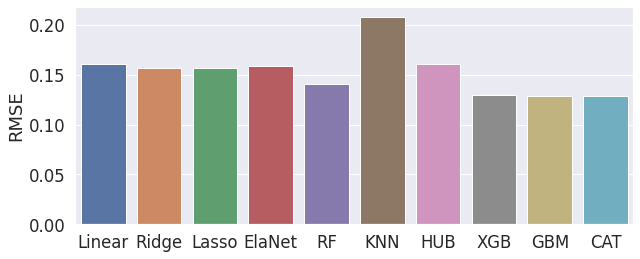

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

In [ ]:
predictions = {'Linear': y_pred_linear, 'Ridge': y_pred_ridge, 'Lasso': y_pred_lasso,
               'ElaNet': y_pred_enet, 'RF': y_pred_rf, 'KNN': y_pred_knn, 'HUB': y_pred_hub, 'PAR': y_pred_par,
               'XGB': y_pred_xgb, 'GBM': y_pred_gbm, 'CAT': y_pred_cat}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

Linear     Ridge     Lasso    ElaNet        RF       KNN       HUB  \
Linear  1.000000  0.996555  0.994135  0.984217  0.961460  0.871797  0.991992   
Ridge   0.996555  1.000000  0.995688  0.986787  0.964188  0.878281  0.993902   
Lasso   0.994135  0.995688  1.000000  0.994037  0.967422  0.880269  0.996209   
ElaNet  0.984217  0.986787  0.994037  1.000000  0.967847  0.886292  0.990008   
RF      0.961460  0.964188  0.967422  0.967847  1.000000  0.873025  0.964166   
KNN     0.871797  0.878281  0.880269  0.886292  0.873025  1.000000  0.882227   
HUB     0.991992  0.993902  0.996209  0.990008  0.964166  0.882227  1.000000   
PAR     0.668835  0.671195  0.670177  0.691434  0.681117  0.797286  0.675115   
XGB     0.962946  0.966095  0.967241  0.963292  0.982921  0.866256  0.961255   
GBM     0.974167  0.976612  0.978487  0.973066  0.981426  0.873830  0.973765   
CAT     0.962408  0.966649  0.969156  0.966740  0.981581  0.870884  0.963144   

             PAR       XGB       GBM       CAT  
Linear  0.668835  0.962946  0.974167  0.962408  
Ridge   0.671195  0.966095  0.976612  0.966649  
Lasso   0.670177  0.967241  0.978487  0.969156  
ElaNet  0.691434  0.963292  0.973066  0.966740  
RF      0.681117  0.982921  0.981426  0.981581  
KNN     0.797286  0.866256  0.873830  0.870884  
HUB     0.675115  0.961255  0.973765  0.963144  
PAR     1.000000  0.676570  0.664055  0.668984  
XGB     0.676570  1.000000  0.989085  0.989427  
GBM     0.664055  0.989085  1.000000  0.990975  
CAT     0.668984  0.989427  0.990975  1.000000

### COMPARACIÓN DE LOS MODELOS R2_SCORE

In [ ]:
list_r2_score = [r2_score_linear, r2_score_ridge, r2_score_lasso, r2_score_enet, r2_score_rf,
               r2_score_knn, r2_score_hub, r2_score_xgb, r2_score_gbm, r2_score_cat,
                r2_score_stack1, r2_score_stack2, r2_score_stack3, r2_score_stack4, r2_score_stack5]
list_regressors_r2_score = ['Lin','Rid','Las','ENet','RF','KNN', 'HUB', 'XGB', 'GBM', 'CAT', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5']

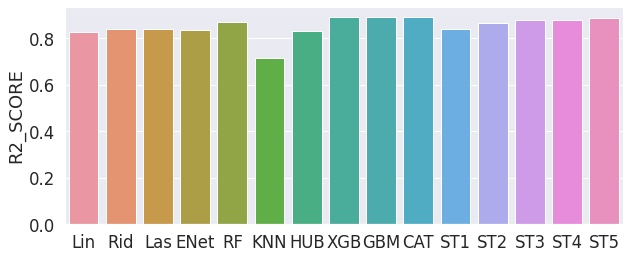

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)
sns.barplot(x=list_regressors_r2_score, y=list_r2_score, ax=ax)
plt.ylabel('R2_SCORE')
plt.show()

COMPROBACIÓN DEL MODELO (MEDIA DE TODOS LOS PREDICTORES)

In [ ]:
y_linear = grid_linear.predict(X_test)
y_ridge = grid_ridge.predict(X_test)
y_lasso = grid_lasso.predict(X_test)
y_enet = grid_enet.predict(X_test)
y_rf = grid_rf.predict(X_test)
y_knn = grid_knn.predict(X_test)
y_hub = grid_hub.predict(X_test)
y_par = grid_par.predict(X_test)
y_xgb = grid_xgb.predict(X_test)
y_gbm = grid_gbm.predict(X_test)
y_cat = grid_cat.predict(X_test)
y_stack1 = grid_stack1.predict(X_test)
y_stack2 = grid_stack2.predict(X_test)
y_stack3 = grid_stack3.predict(X_test)
y_stack4 = grid_stack4.predict(X_test)
y_stack5 = grid_stack5.predict(X_test)

y_mean_models = (y_linear + y_ridge + y_lasso + y_enet + y_rf + y_knn + y_hub + y_par + y_xgb + y_gbm + y_cat + 
                 y_stack1 + y_stack2 + y_stack3 + y_stack4 + y_stack5) / 16.0

print('mean_absolute_error: ', mean_absolute_error(y_test, y_mean_models))
print('mean_squared_error: ', np.sqrt(mean_squared_error(y_test, y_mean_models)))
ratio_mae_mediana = mean_absolute_error(y_test, y_mean_models) / y_test.median()
print("El ratio entre el mae y la mediana del precio es: {}.".format(ratio_mae_mediana))
ratio_mse_media = mean_squared_error(y_test, y_mean_models) / y_test.mean()
print("El ratio entre la raíz cuadrada del mse y la media del precio es: {}".format(np.sqrt(ratio_mse_media)))
r2_score = metrics.r2_score(y_test, y_mean_models)
print('r2_score: ', r2_score)

mean_absolute_error:  0.08018747941300626
mean_squared_error:  0.129896451526919
El ratio entre el mae y la mediana del precio es: 0.006678214662316102.
El ratio entre la raíz cuadrada del mse y la media del precio es: 0.03745601045708637
r2_score:  0.8885514956639612


### CREACIÓN DEL FICHERO PARA SUBIR A KAGGLE

In [ ]:
df_submit = pd.DataFrame()
df_submit['Id'] = indice

SE APLICA EL MODELO

In [ ]:
# Media de los modelos
y_linear = grid_linear.predict(df_test)
y_ridge = grid_ridge.predict(df_test)
y_lasso = grid_lasso.predict(df_test)
y_enet = grid_enet.predict(df_test)
y_rf = grid_rf.predict(df_test)
y_knn = grid_knn.predict(df_test)
y_hub = grid_hub.predict(df_test)
y_par = grid_par.predict(df_test)
y_xgb = grid_xgb.predict(df_test)
y_gbm = grid_gbm.predict(df_test)
y_cat = grid_cat.predict(df_test)
y_stack1 = grid_stack1.predict(df_test)
y_stack2 = grid_stack2.predict(df_test)
y_stack3 = grid_stack3.predict(df_test)
y_stack4 = grid_stack4.predict(df_test)
y_stack5 = grid_stack5.predict(df_test)

df_submit['SalePrice'] = 0.35 * y_stack1 + 0.15 * y_xgb + 0.15 * y_gbm + 0.1 * y_cat + 0.25 * y_stack4
df_submit['SalePrice'] = np.expm1(df_submit['SalePrice'])
df_submit.head()

Id      SalePrice
0  1461  115226.892040
1  1462  156551.687504
2  1463  184021.621239
3  1464  192699.171383
4  1465  181925.032462

SE CREA EL FICHERO

In [ ]:
df_submit.to_csv('submission.csv')